In [10]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from numpy.random import shuffle
import random
np.set_printoptions(threshold=np.inf)

batch_size = 64  # Batch size for training.
epochs = 350  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 26000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'
print(epochs)

350


In [36]:
import io

data_path = 'fra-eng/fra.txt'
file = open('dataset.txt','w',encoding="utf-8")

#with io.open(data_path, 'w', encoding=character_encoding) as file:
#    file.write(unicode_text)

check=0
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split(' ')
    #f.write(foo.encode('utf8'))
    if(check==0):
        file.write(line)
    else:
        file.write('\n'+line)
    check=1    
    #print(line)
for line in lines[:10000]:
    input_text, target_text = line.split(' ')
    file.write('\n'+target_text+' '+target_text)
    
file.close()    

In [11]:
# Vectorize the data.
data_path = 'dataset.txt'
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
    print(len(lines))
    print(lines[0])
    random.shuffle(lines)
    print(lines[0])
    
print(num_samples)    
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split(' ')
    # We use space(' ') as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = ' ' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

28000
﻿অ্যান্ডেজ অ্যান্ডেজ
রেন্ডি রেন্ডি
26000
Number of samples: 26000
Number of unique input tokens: 66
Number of unique output tokens: 67
Max sequence length for inputs: 22
Max sequence length for outputs: 22


In [12]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [13]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [14]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print(epochs)
# Run training
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

350
Train on 20800 samples, validate on 5200 samples
Epoch 1/350
20800/20800 [==============================] - 113s 5ms/step - loss: 1.0021 - acc: 0.7284 - val_loss: 0.8923 - val_acc: 0.7606
Epoch 2/350
20800/20800 [==============================] - 110s 5ms/step - loss: 0.8224 - acc: 0.7756 - val_loss: 0.7590 - val_acc: 0.7897
Epoch 3/350
20800/20800 [==============================] - 109s 5ms/step - loss: 0.6784 - acc: 0.8106 - val_loss: 0.6242 - val_acc: 0.8265
Epoch 4/350
20800/20800 [==============================] - 110s 5ms/step - loss: 0.5523 - acc: 0.8427 - val_loss: 0.5119 - val_acc: 0.8524
Epoch 5/350
20800/20800 [==============================] - 110s 5ms/step - loss: 0.4411 - acc: 0.8720 - val_loss: 0.4046 - val_acc: 0.8808
Epoch 6/350
20800/20800 [==============================] - 110s 5ms/step - loss: 0.3431 - acc: 0.8971 - val_loss: 0.3351 - val_acc: 0.8927
Epoch 7/350
20800/20800 [==============================] - 109s 5ms/step - loss: 0.2613 - acc: 0.9173 - val_loss:

20800/20800 [==============================] - 116s 6ms/step - loss: 0.0023 - acc: 0.8971 - val_loss: 0.0377 - val_acc: 0.8895
Epoch 60/350
20800/20800 [==============================] - 116s 6ms/step - loss: 0.0023 - acc: 0.8909 - val_loss: 0.0408 - val_acc: 0.8433
Epoch 61/350
20800/20800 [==============================] - 116s 6ms/step - loss: 0.0020 - acc: 0.8430 - val_loss: 0.0389 - val_acc: 0.8086
Epoch 62/350
20800/20800 [==============================] - 115s 6ms/step - loss: 0.0021 - acc: 0.8087 - val_loss: 0.0392 - val_acc: 0.7450
Epoch 63/350
20800/20800 [==============================] - 115s 6ms/step - loss: 0.0021 - acc: 0.8328 - val_loss: 0.0433 - val_acc: 0.8460
Epoch 64/350
20800/20800 [==============================] - 114s 5ms/step - loss: 0.0021 - acc: 0.8353 - val_loss: 0.0437 - val_acc: 0.8712
Epoch 65/350
20800/20800 [==============================] - 115s 6ms/step - loss: 0.0020 - acc: 0.8106 - val_loss: 0.0390 - val_acc: 0.7828
Epoch 66/350
20800/20800 [=======

20800/20800 [==============================] - 115s 6ms/step - loss: 0.0010 - acc: 0.7816 - val_loss: 0.0406 - val_acc: 0.7157
Epoch 118/350
20800/20800 [==============================] - 115s 6ms/step - loss: 0.0010 - acc: 0.7496 - val_loss: 0.0409 - val_acc: 0.6729
Epoch 119/350
20800/20800 [==============================] - 116s 6ms/step - loss: 8.8193e-04 - acc: 0.6981 - val_loss: 0.0444 - val_acc: 0.6965
Epoch 120/350
20800/20800 [==============================] - 115s 6ms/step - loss: 8.6733e-04 - acc: 0.7128 - val_loss: 0.0419 - val_acc: 0.6925
Epoch 121/350
20800/20800 [==============================] - 115s 6ms/step - loss: 8.7398e-04 - acc: 0.7407 - val_loss: 0.0391 - val_acc: 0.7934
Epoch 122/350
20800/20800 [==============================] - 117s 6ms/step - loss: 0.0010 - acc: 0.7688 - val_loss: 0.0401 - val_acc: 0.7397
Epoch 123/350
20800/20800 [==============================] - 115s 6ms/step - loss: 8.0442e-04 - acc: 0.7231 - val_loss: 0.0402 - val_acc: 0.7063
Epoch 124/3

20800/20800 [==============================] - 115s 6ms/step - loss: 6.4384e-04 - acc: 0.7357 - val_loss: 0.0429 - val_acc: 0.7225
Epoch 174/350
20800/20800 [==============================] - 114s 5ms/step - loss: 3.6451e-04 - acc: 0.7312 - val_loss: 0.0425 - val_acc: 0.7114
Epoch 175/350
20800/20800 [==============================] - 115s 6ms/step - loss: 4.8054e-04 - acc: 0.7584 - val_loss: 0.0415 - val_acc: 0.7385
Epoch 176/350
20800/20800 [==============================] - 115s 6ms/step - loss: 5.2828e-04 - acc: 0.7557 - val_loss: 0.0421 - val_acc: 0.7749
Epoch 177/350
20800/20800 [==============================] - 115s 6ms/step - loss: 4.0031e-04 - acc: 0.8010 - val_loss: 0.0449 - val_acc: 0.8419
Epoch 178/350
20800/20800 [==============================] - 116s 6ms/step - loss: 5.7209e-04 - acc: 0.8217 - val_loss: 0.0423 - val_acc: 0.7939
Epoch 179/350
20800/20800 [==============================] - 115s 6ms/step - loss: 7.6343e-04 - acc: 0.7885 - val_loss: 0.0433 - val_acc: 0.7303

20800/20800 [==============================] - 114s 5ms/step - loss: 4.0805e-04 - acc: 0.7869 - val_loss: 0.0451 - val_acc: 0.7770
Epoch 230/350
20800/20800 [==============================] - 115s 6ms/step - loss: 3.9419e-04 - acc: 0.8024 - val_loss: 0.0435 - val_acc: 0.7892
Epoch 231/350
20800/20800 [==============================] - 115s 6ms/step - loss: 2.1794e-04 - acc: 0.8067 - val_loss: 0.0443 - val_acc: 0.8129
Epoch 232/350
20800/20800 [==============================] - 115s 6ms/step - loss: 3.2116e-04 - acc: 0.7997 - val_loss: 0.0425 - val_acc: 0.7970
Epoch 233/350
20800/20800 [==============================] - 115s 6ms/step - loss: 2.9210e-04 - acc: 0.8127 - val_loss: 0.0441 - val_acc: 0.8390
Epoch 234/350
20800/20800 [==============================] - 114s 5ms/step - loss: 4.8574e-04 - acc: 0.8429 - val_loss: 0.0432 - val_acc: 0.8125
Epoch 235/350
20800/20800 [==============================] - 120s 6ms/step - loss: 4.7511e-04 - acc: 0.8060 - val_loss: 0.0428 - val_acc: 0.8019

20800/20800 [==============================] - 109s 5ms/step - loss: 2.8556e-04 - acc: 0.7505 - val_loss: 0.0472 - val_acc: 0.7520
Epoch 286/350
20800/20800 [==============================] - 111s 5ms/step - loss: 3.2287e-04 - acc: 0.7595 - val_loss: 0.0458 - val_acc: 0.7822
Epoch 287/350
20800/20800 [==============================] - 108s 5ms/step - loss: 3.1284e-04 - acc: 0.7569 - val_loss: 0.0444 - val_acc: 0.7523
Epoch 288/350
20800/20800 [==============================] - 111s 5ms/step - loss: 3.3930e-04 - acc: 0.7462 - val_loss: 0.0453 - val_acc: 0.7658
Epoch 289/350
20800/20800 [==============================] - 107s 5ms/step - loss: 2.1770e-04 - acc: 0.7883 - val_loss: 0.0471 - val_acc: 0.7962
Epoch 290/350
20800/20800 [==============================] - 109s 5ms/step - loss: 3.7996e-04 - acc: 0.8076 - val_loss: 0.0471 - val_acc: 0.8064
Epoch 291/350
20800/20800 [==============================] - 108s 5ms/step - loss: 3.2280e-04 - acc: 0.7844 - val_loss: 0.0471 - val_acc: 0.7706

20800/20800 [==============================] - 109s 5ms/step - loss: 3.0459e-04 - acc: 0.7218 - val_loss: 0.0473 - val_acc: 0.7412
Epoch 342/350
20800/20800 [==============================] - 109s 5ms/step - loss: 2.3602e-04 - acc: 0.7090 - val_loss: 0.0473 - val_acc: 0.6748
Epoch 343/350
20800/20800 [==============================] - 109s 5ms/step - loss: 2.4956e-04 - acc: 0.7181 - val_loss: 0.0471 - val_acc: 0.7457
Epoch 344/350
20800/20800 [==============================] - 109s 5ms/step - loss: 2.5210e-04 - acc: 0.7331 - val_loss: 0.0488 - val_acc: 0.7064
Epoch 345/350
20800/20800 [==============================] - 109s 5ms/step - loss: 1.5469e-04 - acc: 0.7302 - val_loss: 0.0477 - val_acc: 0.7421
Epoch 346/350
20800/20800 [==============================] - 109s 5ms/step - loss: 2.0938e-04 - acc: 0.7506 - val_loss: 0.0507 - val_acc: 0.7597
Epoch 347/350
20800/20800 [==============================] - 109s 5ms/step - loss: 1.8498e-04 - acc: 0.7715 - val_loss: 0.0481 - val_acc: 0.7934

C:\Users\RANA_CSE\Anaconda3\lib\site-packages\keras\engine\topology.py:2361: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [22]:
# Next: inference mode (sampling).
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
data_path = 'fra-eng/fra.txt'
print("kire")
model = load_model('s2s.h5')


encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index[' ']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence




def get_input_data(test_txt):
    #txt = input()
    txt=test_txt
    
    encoder_input_data = np.zeros(
    (len(txt), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
    
    txt = txt.replace(' ', '')
    
    for t, char in enumerate(txt):
        encoder_input_data[0, t, input_token_index[char]] = 1.
        
    return encoder_input_data
    
    
    
    
# Take one sequence (part of the training set)
# for trying out decoding.
#input_seq = encoder_input_data[seq_index: seq_index + 1]

with open(data_path, 'r', encoding='utf-8') as f:
    test_lines = f.read().split('\n')

test_input_texts=[]
test_target_texts=[]
for line in test_lines[30000: 40005]:
    #print(line)
    test_input_text, test_target_text = line.split(' ')
    #print(test_input_text)
    test_input_texts.append(test_input_text)
    test_target_texts.append(test_target_text+'\n')
    
#print(test_input_texts)   

total_test_input=0
total_accuracy=0

for i in range(10000):
    total_test_input=total_test_input+1
    input_seq = get_input_data(test_input_texts[i])
    decoded_sentence = decode_sequence(input_seq)
    if (decoded_sentence==test_target_texts[i]):
        total_accuracy=total_accuracy+1
        #print('hoiche')
        
    print('Input sentence:',   test_input_texts[i])
    print('Decoded sentence:', decoded_sentence)
    #print(decoded_sentence[6])
    print('Target sentence:',  test_target_texts[i])
    #print(test_target_texts[i][6])
  
    
print('total_test_input:', total_test_input)
print('total_accuracy:', total_accuracy)
print('result:', (total_accuracy/total_test_input)*100,'%')

#yhat = model.predict(input_seq, verbose=0)
#print(yhat)

kire
Input sentence: আইনগুলোয়
Decoded sentence: আইন

Target sentence: আইন

Input sentence: পরিতোষকে
Decoded sentence: পরিতোষ

Target sentence: পরিতোষ

Input sentence: আইনগুলোর
Decoded sentence: আইন

Target sentence: আইন

Input sentence: ট্রোজানের
Decoded sentence: ট্রোজান

Target sentence: ট্রোজান

Input sentence: এনটিপিসিকে
Decoded sentence: এনটিপিসি

Target sentence: এনটিপিসি

Input sentence: গণনাতে
Decoded sentence: গণনা

Target sentence: গণনা

Input sentence: থাইয়ের
Decoded sentence: থাই

Target sentence: থাই

Input sentence: বার্সেলোনারই
Decoded sentence: বার্সেলোন

Target sentence: বার্সেলোনা

Input sentence: লিগনিনের
Decoded sentence: লিগনিন

Target sentence: লিগনিন

Input sentence: কুর্মীর
Decoded sentence: কুর্মী

Target sentence: কুর্মী

Input sentence: মেশিনগুলো
Decoded sentence: মেশিন

Target sentence: মেশিন

Input sentence: ফেরারির
Decoded sentence: ফেরারি

Target sentence: ফেরারি

Input sentence: অ্যাভাটারের
Decoded sentence: অ্যাভাটা

Target sentence: অ্যাভাটার

Input se

Input sentence: চাষকেও
Decoded sentence: চাষ

Target sentence: চাষ

Input sentence: নকশায়
Decoded sentence: নকশা

Target sentence: নকশা

Input sentence: বাচ্চাও
Decoded sentence: বাচ্চা

Target sentence: বাচ্চা

Input sentence: অর্জুনকে
Decoded sentence: অর্জুন

Target sentence: অর্জুন

Input sentence: উপনির্বাচনটিতে
Decoded sentence: উপনির্বাচন

Target sentence: উপনির্বাচন

Input sentence: বনভূমিগুলো
Decoded sentence: বনভূমি

Target sentence: বনভূমি

Input sentence: বাচ্চার
Decoded sentence: বাচ্চা

Target sentence: বাচ্চা

Input sentence: গুটির
Decoded sentence: গুটি

Target sentence: গুটি

Input sentence: উর্দুর
Decoded sentence: উর্দু

Target sentence: উর্দু

Input sentence: সঞ্চয়পত্রই
Decoded sentence: স্বপোচরত্বে

Target sentence: সঞ্চয়পত্র

Input sentence: গণগ্রেপ্তারের
Decoded sentence: গণগ্রেপ্তার

Target sentence: গণগ্রেপ্তার

Input sentence: বন্দীকে
Decoded sentence: বন্দী

Target sentence: বন্দী

Input sentence: দিকটা
Decoded sentence: দিক

Target sentence: দিক

Input sente

Input sentence: মহিদুলকে
Decoded sentence: মহিদুল

Target sentence: মহিদুল

Input sentence: নিশ্চিতের
Decoded sentence: নিশ্চিত

Target sentence: নিশ্চিত

Input sentence: সোজাসাপটাও
Decoded sentence: সোজাসাপ

Target sentence: সোজাসাপটা

Input sentence: প্রেখটকে
Decoded sentence: প্রেট

Target sentence: প্রেখট

Input sentence: সৃষ্টির
Decoded sentence: সৃষ্টি

Target sentence: সৃষ্টি

Input sentence: জনপদে
Decoded sentence: জনপ

Target sentence: জনপদ

Input sentence: বিএসএমএমইউতে
Decoded sentence: বিএসএমএমইউ

Target sentence: বিএসএমএমইউ

Input sentence: প্রতিষ্ঠানগুলোকেই
Decoded sentence: প্রতিষ্ঠান

Target sentence: প্রতিষ্ঠান

Input sentence: প্রতিষ্ঠানগুলোকেও
Decoded sentence: প্রতিষ্ঠান

Target sentence: প্রতিষ্ঠান

Input sentence: সৃষ্টিই
Decoded sentence: সৃষ্টি

Target sentence: সৃষ্টি

Input sentence: নিয়ন্ত্রণব্যবস্থাকে
Decoded sentence: নিয়ন্ত্রণব্যবস্থা

Target sentence: নিয়ন্ত্রণব্যবস্থা

Input sentence: কারনেবোর
Decoded sentence: কারনেঙ্কো

Target sentence: কারনেবো

Input s

Input sentence: গুজবও
Decoded sentence: গুজব

Target sentence: গুজব

Input sentence: ট্রোজানটি
Decoded sentence: ট্রোজান

Target sentence: ট্রোজান

Input sentence: যাজকের
Decoded sentence: যাজক

Target sentence: যাজক

Input sentence: গুজবই
Decoded sentence: গুজব

Target sentence: গুজব

Input sentence: অচলদের
Decoded sentence: অচলদ

Target sentence: অচল

Input sentence: নৌবন্দরে
Decoded sentence: নৌবন্দ

Target sentence: নৌবন্দর

Input sentence: গণমাধ্যমগুলো
Decoded sentence: গণমাধ্যম

Target sentence: গণমাধ্যম

Input sentence: ভারতে
Decoded sentence: ভার

Target sentence: ভারত

Input sentence: চেয়ারম্যানঘাটে
Decoded sentence: চেয়ারম্যান

Target sentence: চেয়ারম্যানঘাট

Input sentence: ঘুড়িবিদেরা
Decoded sentence: ঘুড়িবিদ

Target sentence: ঘুড়িবিদ

Input sentence: গুজবে
Decoded sentence: গুজব

Target sentence: গুজব

Input sentence: পেলেগ্রিনির
Decoded sentence: পেলেগ্রিনি

Target sentence: পেলেগ্রিনি

Input sentence: পতনে
Decoded sentence: পতন

Target sentence: পতন

Input sentence: সুইচ

Input sentence: আহতেরা
Decoded sentence: আহতে

Target sentence: আহত

Input sentence: জানিয়েও
Decoded sentence: জানিয়ে

Target sentence: জানি

Input sentence: কমান্ডাররা
Decoded sentence: কমান্ডারা

Target sentence: কমান্ডার

Input sentence: খেলোয়াড়টির
Decoded sentence: খেলোয়াড়

Target sentence: খেলোয়াড়

Input sentence: ক্যাননের
Decoded sentence: ক্যানন

Target sentence: ক্যানন

Input sentence: জর্জের
Decoded sentence: জর্জ

Target sentence: জর্জ

Input sentence: জানিয়েই
Decoded sentence: জানিয়ে

Target sentence: জানি

Input sentence: বইয়েই
Decoded sentence: বই

Target sentence: বই

Input sentence: বইয়েও
Decoded sentence: বই

Target sentence: বই

Input sentence: কাতারকে
Decoded sentence: কাতা

Target sentence: কাতার

Input sentence: বইয়ের
Decoded sentence: বয়

Target sentence: বই

Input sentence: বিএমএফএর
Decoded sentence: বিএমএফএ

Target sentence: বিএমএফএ

Input sentence: গাদ্দাফিপন্থীরা
Decoded sentence: গ্যাদানিক্পী

Target sentence: গাদ্দাফিপন্থী

Input sentence: পণ্যকরণের
Decoded s

Input sentence: খবরকেও
Decoded sentence: খবর

Target sentence: খবর

Input sentence: আপলোডের
Decoded sentence: আপলোড

Target sentence: আপলোড

Input sentence: মেহরুদিনকে
Decoded sentence: মেহরুদিন

Target sentence: মেহরুদিন

Input sentence: কাজিনকে
Decoded sentence: কাজিন

Target sentence: কাজিন

Input sentence: কার্নিশেই
Decoded sentence: কার্নিশ

Target sentence: কার্নিশে

Input sentence: ব্রংকহর্স্টের
Decoded sentence: ব্রংহকর্ম

Target sentence: ব্রংকহর্স্ট

Input sentence: খুবির
Decoded sentence: খুবি

Target sentence: খুবি

Input sentence: বার্তাবাহককে
Decoded sentence: বার্তাবাহক

Target sentence: বার্তাবাহক

Input sentence: রাজিনের
Decoded sentence: রাজিন

Target sentence: রাজিন

Input sentence: হাজীগঞ্জে
Decoded sentence: হাজীগঞ্জ

Target sentence: হাজীগঞ্জ

Input sentence: সংশোধনীগুলো
Decoded sentence: সংশোধনী

Target sentence: সংশোধনী

Input sentence: নিয়াই
Decoded sentence: নিয়া

Target sentence: নিয়া

Input sentence: সুজনকে
Decoded sentence: সুজন

Target sentence: সুজন

Inpu

Input sentence: প্রাপ্তির
Decoded sentence: প্রাপ্তি

Target sentence: প্রাপ্তি

Input sentence: টার্মিনালটির
Decoded sentence: টার্মিনাল

Target sentence: টার্মিনাল

Input sentence: ব্যাংকিংয়ের
Decoded sentence: ব্যাংকিং

Target sentence: ব্যাংকিং

Input sentence: উপদ্রবে
Decoded sentence: উপদ্রব

Target sentence: উপদ্রব

Input sentence: গোলাপগুলো
Decoded sentence: গোলাপ

Target sentence: গোলাপ

Input sentence: বন্টনের
Decoded sentence: বন্টন

Target sentence: বন্টন

Input sentence: মুরগির
Decoded sentence: মুরগি

Target sentence: মুরগি

Input sentence: ঋণখেলাপিরা
Decoded sentence: ঋণখেলাপি

Target sentence: ঋণখেলাপি

Input sentence: মৈত্রর
Decoded sentence: মৈত্র

Target sentence: মৈত্র

Input sentence: মুরগিই
Decoded sentence: মুরগি

Target sentence: মুরগি

Input sentence: টিনশেডগুলোর
Decoded sentence: টিনশেড

Target sentence: টিনশেড

Input sentence: দৃশ্যটায়
Decoded sentence: দৃশ্যস

Target sentence: দৃশ্য

Input sentence: মুরগিও
Decoded sentence: মুরগি

Target sentence: মুরগি

Inp

Input sentence: প্রত্নতত্ত্বে
Decoded sentence: প্রত্নতত্ত্র

Target sentence: প্রত্নতত্ত্ব

Input sentence: ফিরেই
Decoded sentence: ফিরে

Target sentence: ফি

Input sentence: চিলড্রেনে
Decoded sentence: চিলড্রেন

Target sentence: চিলড্রেন

Input sentence: খুমির
Decoded sentence: খুমি

Target sentence: খুমি

Input sentence: লাহাবের
Decoded sentence: লাহাব

Target sentence: লাহাব

Input sentence: গরমকে
Decoded sentence: গরম

Target sentence: গরম

Input sentence: কানপুরের
Decoded sentence: কাপনুর

Target sentence: কানপুরে

Input sentence: বলিভিয়ার
Decoded sentence: বলিভিয়া

Target sentence: বলিভিয়া

Input sentence: অর্ধেকটাকে
Decoded sentence: অর্ধেকো

Target sentence: অর্ধেকটা

Input sentence: বলিভিয়ায়
Decoded sentence: বলিভিয়া

Target sentence: বলিভিয়া

Input sentence: উৎদনের
Decoded sentence: উৎদন

Target sentence: উৎদন

Input sentence: করেরহাটে
Decoded sentence: কররেহা

Target sentence: করেরহাট

Input sentence: অ্যাটেনডেন্টকে
Decoded sentence: অ্যাটেন্টেন

Target sentence: অ্যাটেনডেন

Input sentence: পর্বতশৃঙ্গে
Decoded sentence: পর্বতঙ্গ

Target sentence: পর্বতশৃঙ্গ

Input sentence: অ্যাঙ্গলিসর
Decoded sentence: অ্যাঙ্গিলস

Target sentence: অ্যাঙ্গলিস

Input sentence: চিকিৎসাবর্জ্যে
Decoded sentence: চিকিৎসাব্রেজ্য

Target sentence: চিকিৎসাবর্জ্য

Input sentence: ভাষাবিচ্ছেদের
Decoded sentence: ভাষাবিচি

Target sentence: ভাষাবিচ্ছেদ

Input sentence: নীতিনির্ধারককে
Decoded sentence: নীতিনিক্যা

Target sentence: নীতিনির্ধারক

Input sentence: পাটনার
Decoded sentence: পাটনা

Target sentence: পাটনা

Input sentence: সাবধানেই
Decoded sentence: সাবধান

Target sentence: সাবধান

Input sentence: প্রক্টরকে
Decoded sentence: প্রক্টর

Target sentence: প্রক্টর

Input sentence: পর্যবেক্ষণেও
Decoded sentence: পর্যবেক্ষণ

Target sentence: পর্যবেক্ষণ

Input sentence: সাবেরের
Decoded sentence: সাবের

Target sentence: সাব

Input sentence: প্রক্টররা
Decoded sentence: প্রক্টর

Target sentence: প্রক্টর

Input sentence: মহাব্যবস্থাপককে
Decoded sentence: মহাব্যবস্থা

Target sentence: মহাব্য

Input sentence: স্পিডবোটে
Decoded sentence: স্পিডবোট

Target sentence: স্পিডবোট

Input sentence: উনিই
Decoded sentence: উনি

Target sentence: উনি

Input sentence: বিজ্ঞপ্তিতে
Decoded sentence: বিজ্ঞপ্তি

Target sentence: বিজ্ঞপ্তি

Input sentence: উদ্ভাবনে
Decoded sentence: উদ্ভাবন

Target sentence: উদ্ভাবন

Input sentence: রয়ের
Decoded sentence: রয়

Target sentence: রয়

Input sentence: পাঠাগারে
Decoded sentence: পাঠাগার

Target sentence: পাঠাগার

Input sentence: সিসিকে
Decoded sentence: সিসি

Target sentence: সিসি

Input sentence: মরিনহোর
Decoded sentence: মরিনহো

Target sentence: মরিনহো

Input sentence: সংর্ঘষে
Decoded sentence: সংর্ষঘ

Target sentence: সংর্ঘষ

Input sentence: সাবেরকে
Decoded sentence: সাব

Target sentence: সাব

Input sentence: উদ্যোগটিকে
Decoded sentence: উদ্যোগ

Target sentence: উদ্যোগ

Input sentence: বিয়েটাকে
Decoded sentence: বিয়েটা

Target sentence: বিয়ে

Input sentence: ভূমিকাকে
Decoded sentence: ভূমিকা

Target sentence: ভূমিকা

Input sentence: মরিনহোও
Decoded

Input sentence: গফরগাঁয়ের
Decoded sentence: গফরগাঁও

Target sentence: গফরগাঁয়ে

Input sentence: টনিকে
Decoded sentence: টনি

Target sentence: টনি

Input sentence: বক্তব্যেরও
Decoded sentence: বক্তব্য

Target sentence: বক্তব্য

Input sentence: হেলিকপ্টারে
Decoded sentence: হেলিকপ্টার

Target sentence: হেলিকপ্টার

Input sentence: বিধানেরও
Decoded sentence: বিধান

Target sentence: বিধান

Input sentence: ফরোয়ার্ডকে
Decoded sentence: ফরোয়ার্ড

Target sentence: ফরোয়ার্ড

Input sentence: রাশকে
Decoded sentence: রাশ

Target sentence: রাশ

Input sentence: সমদূরত্বের
Decoded sentence: সমদূর্ত

Target sentence: সমদূরত্ব

Input sentence: চুন্নুর
Decoded sentence: চুন্নু

Target sentence: চুন্নু

Input sentence: আর্তির
Decoded sentence: আর্তি

Target sentence: আর্তি

Input sentence: কাওয়ানও
Decoded sentence: কাওয়ান

Target sentence: কাওয়ান

Input sentence: আকতারের
Decoded sentence: আকতার

Target sentence: আকতার

Input sentence: তাইয়েবার
Decoded sentence: তাইয়েবা

Target sentence: তাইয়েবা

Input sen

Input sentence: পুকুরটা
Decoded sentence: পুকুর

Target sentence: পুকুর

Input sentence: পুকুরটি
Decoded sentence: পুকুর

Target sentence: পুকুর

Input sentence: মিথ্যারই
Decoded sentence: মিথ্যা

Target sentence: মিথ্যা

Input sentence: সোনালিচুলোকে
Decoded sentence: সোনালিলো

Target sentence: সোনালিচুলো

Input sentence: পুনর্নিমাণের
Decoded sentence: পুনর্নিমা

Target sentence: পুনর্নিমাণ

Input sentence: খুলির
Decoded sentence: খুলি

Target sentence: খুলি

Input sentence: উচ্চমূল্যের
Decoded sentence: উচ্চমূল্য

Target sentence: উচ্চমূল্য

Input sentence: মৌয়ালের
Decoded sentence: মৌয়াল

Target sentence: মৌয়াল

Input sentence: সিইসিকে
Decoded sentence: সিইসি

Target sentence: সিইসি

Input sentence: বাহুবলে
Decoded sentence: বাহুবল

Target sentence: বাহুবল

Input sentence: অসহায়ত্বের
Decoded sentence: অসহায়ত্ব

Target sentence: অসহায়ত্ব

Input sentence: নদীশাসনের
Decoded sentence: নদীশাসন

Target sentence: নদীশাসন

Input sentence: প্রণেতারাও
Decoded sentence: প্রণেতা

Target sentence

Input sentence: নিয়োগপ্রক্রিয়ার
Decoded sentence: নিয়োগপ্রক্ষিয়ান

Target sentence: নিয়োগপ্রক্রিয়া

Input sentence: বিজয়ীকে
Decoded sentence: বিজয়ী

Target sentence: বিজয়ী

Input sentence: থ্রোতে
Decoded sentence: ক্যোত

Target sentence: থ্রো

Input sentence: মোহনগঞ্জে
Decoded sentence: মোহনগঞ্জ

Target sentence: মোহনগঞ্জ

Input sentence: আখুঞ্জীকে
Decoded sentence: আখুজ্ঞী

Target sentence: আখুঞ্জী

Input sentence: মোড়লকে
Decoded sentence: মোড়ল

Target sentence: মোড়ল

Input sentence: বাকপ্রতিবন্ধীর
Decoded sentence: বাকপ্রতিন্ধবী

Target sentence: বাকপ্রতিবন্ধী

Input sentence: আহসানের
Decoded sentence: আহসান

Target sentence: আহসান

Input sentence: বিজ্ঞপ্তিটি
Decoded sentence: বিজ্ঞপ্তি

Target sentence: বিজ্ঞপ্তি

Input sentence: গবেষণাকাজে
Decoded sentence: গবেষণাজার

Target sentence: গবেষণাকাজ

Input sentence: দাবিকে
Decoded sentence: দাবি

Target sentence: দাবি

Input sentence: কৌটাগুলো
Decoded sentence: কৌটা

Target sentence: কৌটা

Input sentence: বরাকে
Decoded sentence: বরা

T

Input sentence: ব্রুককে
Decoded sentence: ব্রুক

Target sentence: ব্রুক

Input sentence: এসপিরা
Decoded sentence: এসপি

Target sentence: এসপি

Input sentence: কুলাউড়াসভার
Decoded sentence: কুলাউড়াসার

Target sentence: কুলাউড়াসভা

Input sentence: রাশেদের
Decoded sentence: রাশেদ

Target sentence: রাশেদ

Input sentence: ডালডার
Decoded sentence: ডালডার

Target sentence: ডালডা

Input sentence: তথ্যচিত্রও
Decoded sentence: তথ্যচিত্র

Target sentence: তথ্যচিত্র

Input sentence: ফিদের
Decoded sentence: ফিদ

Target sentence: ফিদে

Input sentence: তথ্যচিত্রই
Decoded sentence: তথ্যচিত্র

Target sentence: তথ্যচিত্র

Input sentence: ইউসেপকে
Decoded sentence: ইউসেপ

Target sentence: ইউসেপ

Input sentence: ট্রেন্টও
Decoded sentence: ট্রেন্ট

Target sentence: ট্রেন্ট

Input sentence: বুগতির
Decoded sentence: বৈগুতি

Target sentence: বুগতি

Input sentence: অপরাধকে
Decoded sentence: অপরাধ

Target sentence: অপরাধ

Input sentence: উত্তরাধিকারকে
Decoded sentence: উত্তরাধিকার

Target sentence: উত্তরাধিকার



Input sentence: ব্যক্তিশ্রেণীর
Decoded sentence: ব্যক্তিশ্রণ

Target sentence: ব্যক্তি

Input sentence: কিকের
Decoded sentence: কি

Target sentence: কি

Input sentence: গ্যাসকূপের
Decoded sentence: গ্যাসকূপ

Target sentence: গ্যাসকূপ

Input sentence: তাজিকিস্তানের
Decoded sentence: তাজিকিস্তান

Target sentence: তাজিকিস্তান

Input sentence: পয়সায়ও
Decoded sentence: পয়সায়

Target sentence: পয়সা

Input sentence: শাহবাজের
Decoded sentence: শাহবাজ

Target sentence: শাহবাজ

Input sentence: শারজায়ই
Decoded sentence: শারজা

Target sentence: শারজা

Input sentence: সুবর্ণার
Decoded sentence: সুবর্ণ

Target sentence: সুবর্ণা

Input sentence: সরালেও
Decoded sentence: সরাল

Target sentence: সরালে

Input sentence: ঝুলের
Decoded sentence: ঝুল

Target sentence: ঝুল

Input sentence: অন্যকেও
Decoded sentence: অন্য

Target sentence: অন্যকে

Input sentence: কুরিয়ারগুলোও
Decoded sentence: কুরিয়ার

Target sentence: কুরিয়ার

Input sentence: অধিবেশনটি
Decoded sentence: অধিবেশন

Target sentence: অধিবেশন

Input

Input sentence: সোহাগীর
Decoded sentence: সোহাগী

Target sentence: সোহাগী

Input sentence: যুগোশ্লাভিয়ার
Decoded sentence: যুগোশাল্পিয়া

Target sentence: যুগোশ্লাভিয়া

Input sentence: অধিবেশনেও
Decoded sentence: অধিবেশন

Target sentence: অধিবেশন

Input sentence: থামলেই
Decoded sentence: থামল

Target sentence: থামল

Input sentence: সাইটও
Decoded sentence: সাইট

Target sentence: সাইট

Input sentence: সাইটই
Decoded sentence: সাইট

Target sentence: সাইট

Input sentence: আকাশেই
Decoded sentence: আকাশ

Target sentence: আকাশ

Input sentence: অধিবেশনেই
Decoded sentence: অধিবেশন

Target sentence: অধিবেশন

Input sentence: কথিকায়
Decoded sentence: কথিকা

Target sentence: কথিকা

Input sentence: তোদের
Decoded sentence: তোদ

Target sentence: তো

Input sentence: দীর্ঘদিনের
Decoded sentence: দীর্ঘিন

Target sentence: দীর্ঘদিন

Input sentence: মাত্রাগুলোর
Decoded sentence: মাত্রা

Target sentence: মাত্রা

Input sentence: সকলেরই
Decoded sentence: সকল

Target sentence: সকল

Input sentence: এনভিডিয়ার
Deco

Input sentence: গরিবকে
Decoded sentence: গরিব

Target sentence: গরিব

Input sentence: গরুগুলোকে
Decoded sentence: গরু

Target sentence: গরু

Input sentence: পথিকৃত্ও
Decoded sentence: পথিকৃত্

Target sentence: পথিকৃত্

Input sentence: উমার
Decoded sentence: উমার

Target sentence: উমা

Input sentence: সাকলায়েনকে
Decoded sentence: সাকলায়েন

Target sentence: সাকলায়েন

Input sentence: বেড়িবাঁধগুলোর
Decoded sentence: বেড়িবাঁধ

Target sentence: বেড়িবাঁধ

Input sentence: পাঠ্যক্রমের
Decoded sentence: পাঠ্যক্রম

Target sentence: পাঠ্যক্রম

Input sentence: মাংসে
Decoded sentence: মাংস

Target sentence: মাংস

Input sentence: সংস্কারপন্থীরা
Decoded sentence: সংস্থারপন্কী

Target sentence: সংস্কারপন্থী

Input sentence: ইশান্তের
Decoded sentence: ইশান্ত

Target sentence: ইশান্ত

Input sentence: ক্রুর
Decoded sentence: ক্রুর

Target sentence: ক্রু

Input sentence: অভ্যুত্থানের
Decoded sentence: অভ্যুত্থান

Target sentence: অভ্যুত্থান

Input sentence: ফিনকে
Decoded sentence: ফিন

Target sentence: ফিন

Input sentence: রিবেরির
Decoded sentence: রিবেরি

Target sentence: রিবেরি

Input sentence: ক্যামব্রিজশায়ারের
Decoded sentence: ক্যাক্রিজামবাজ

Target sentence: ক্যামব্রিজশায়ার

Input sentence: রিকশার
Decoded sentence: রিকশা

Target sentence: রিকশা

Input sentence: চাঙাভাবের
Decoded sentence: চাভাঙাব

Target sentence: চাঙাভাব

Input sentence: সাইফই
Decoded sentence: সাইফ

Target sentence: সাইফ

Input sentence: রিবেরিই
Decoded sentence: রিবেরি

Target sentence: রিবেরি

Input sentence: একেকটার
Decoded sentence: একেক

Target sentence: একেক

Input sentence: রিকশাও
Decoded sentence: রিকশা

Target sentence: রিকশা

Input sentence: পরিবেশটা
Decoded sentence: পরিবেশ

Target sentence: পরিবেশ

Input sentence: পরিবেশটি
Decoded sentence: পরিবেশ

Target sentence: পরিবেশ

Input sentence: অসুবিধাও
Decoded sentence: অসুবিধা

Target sentence: অসুবিধা

Input sentence: লাশটিও
Decoded sentence: লাশ

Target sentence: লাশ

Input sentence: রেলগাড়িতে
Decoded sentence: রেলগাড়ি

Target sentence: রেলগাড়ি

Input se

Input sentence: ন্যাপেরও
Decoded sentence: ন্যাপ

Target sentence: ন্যাপ

Input sentence: বিএসএফেরই
Decoded sentence: বিএসএফ

Target sentence: বিএসএফ

Input sentence: ভোলার
Decoded sentence: ভোলা

Target sentence: ভোলা

Input sentence: পারলারটির
Decoded sentence: পারলার

Target sentence: পারলার

Input sentence: প্রাকদরপত্রে
Decoded sentence: প্রাকদরপত্র

Target sentence: প্রাকদরপত্র

Input sentence: চিন্তাকাঠামোর
Decoded sentence: চিন্তাকাঠামো

Target sentence: চিন্তাকাঠামো

Input sentence: জামালে
Decoded sentence: জামাল

Target sentence: জামাল

Input sentence: নুসরাতের
Decoded sentence: নুসরাত

Target sentence: নুসরাত

Input sentence: ডিরেক্টরিতে
Decoded sentence: ডিরেক্টরি

Target sentence: ডিরেক্টরি

Input sentence: ভোলায়
Decoded sentence: ভোলা

Target sentence: ভোলা

Input sentence: ঘোষণাটি
Decoded sentence: ঘোষণা

Target sentence: ঘোষণা

Input sentence: ঘোষণাটা
Decoded sentence: ঘোষণা

Target sentence: ঘোষণা

Input sentence: জামালও
Decoded sentence: জামাল

Target sentence: জামাল



Input sentence: নভোথিয়েটারে
Decoded sentence: নভোথিয়ে

Target sentence: নভোথিয়েটার

Input sentence: আকাশকে
Decoded sentence: আকাশ

Target sentence: আকাশ

Input sentence: জনপ্রতিনিধিকে
Decoded sentence: জনপ্রতিনিধি

Target sentence: জনপ্রতিনিধি

Input sentence: ছোটার
Decoded sentence: ছোটা

Target sentence: ছোটা

Input sentence: গোষ্ঠীটিকে
Decoded sentence: গোষ্ঠী

Target sentence: গোষ্ঠী

Input sentence: জামিলও
Decoded sentence: জামিল

Target sentence: জামিল

Input sentence: ক্যাফেটেরিয়ার
Decoded sentence: ক্যাফেটরিয়া

Target sentence: ক্যাফেটেরিয়া

Input sentence: জীবনসংগ্রামে
Decoded sentence: জীবনসংগ্রা

Target sentence: জীবনসংগ্রাম

Input sentence: আইএইএর
Decoded sentence: আইএইএ

Target sentence: আইএইএ

Input sentence: খানাকে
Decoded sentence: খানা

Target sentence: খানা

Input sentence: ম্যাথুজকে
Decoded sentence: ম্যাধুজ

Target sentence: ম্যাথুজ

Input sentence: আকিকের
Decoded sentence: আকিক

Target sentence: আকিক

Input sentence: শাহবাগের
Decoded sentence: শাহবাগ

Target senten

Input sentence: চর্চায়
Decoded sentence: চর্চা

Target sentence: চর্চা

Input sentence: কোটবাড়ীতে
Decoded sentence: কোটবাড়ী

Target sentence: কোটবাড়ী

Input sentence: চর্চাও
Decoded sentence: চর্চা

Target sentence: চর্চা

Input sentence: চর্চার
Decoded sentence: চর্চা

Target sentence: চর্চা

Input sentence: উদ্যোগটি
Decoded sentence: উদ্যোগ

Target sentence: উদ্যোগ

Input sentence: উদ্যোগটা
Decoded sentence: উদ্যোগ

Target sentence: উদ্যোগ

Input sentence: ফিতার
Decoded sentence: ফিতা

Target sentence: ফিতা

Input sentence: এক্সটেনশনে
Decoded sentence: এক্সটেনশন

Target sentence: এক্সটেনশন

Input sentence: বিশ্ববিদ্যালয়গুলোর
Decoded sentence: বিশ্ববিদ্যালয়

Target sentence: বিশ্ববিদ্যালয়

Input sentence: ভেড়ানোরও
Decoded sentence: ভেড়ানো

Target sentence: ভেড়ানো

Input sentence: পুঞ্জিতে
Decoded sentence: পুঞ্জি

Target sentence: পুঞ্জি

Input sentence: কুলিয়ার
Decoded sentence: কুলিয়া

Target sentence: কুলিয়া

Input sentence: ফার্মাসিউটিক্যালের
Decoded sentence: ফার্মাসিউটিক্যালস

T

Input sentence: সফরসূচির
Decoded sentence: সফরসূচি

Target sentence: সফরসূচি

Input sentence: খুনির
Decoded sentence: খুনি

Target sentence: খুনি

Input sentence: পাড়াগুলো
Decoded sentence: পাড়া

Target sentence: পাড়া

Input sentence: স্বাস্থ্যব্যবস্থাকে
Decoded sentence: স্বাস্থ্যব্যবস্থা

Target sentence: স্বাস্থ্যব্যবস্থা

Input sentence: গুচ্ছে
Decoded sentence: গুচ্ছে

Target sentence: গুচ্ছ

Input sentence: কালুকে
Decoded sentence: কালু

Target sentence: কালু

Input sentence: বিদায়ই
Decoded sentence: বিদায়

Target sentence: বিদায়

Input sentence: কালুর
Decoded sentence: কালু

Target sentence: কালু

Input sentence: ক্যামেরনেরও
Decoded sentence: ক্যামেনরা

Target sentence: ক্যামেরন

Input sentence: কালীর
Decoded sentence: কালী

Target sentence: কালী

Input sentence: আকালের
Decoded sentence: আকাল

Target sentence: আকাল

Input sentence: প্রোগ্রামিংয়ের
Decoded sentence: প্রোগ্রামিং

Target sentence: প্রোগ্রামিং

Input sentence: হুঁশিয়ারিতে
Decoded sentence: হুঁশিয়া

Target sentence: হ

Input sentence: সলবাকেনের
Decoded sentence: সলবালেশন

Target sentence: সলবাকেন

Input sentence: ফিজির
Decoded sentence: ফিজি

Target sentence: ফিজি

Input sentence: আরশিনগরে
Decoded sentence: আরশিনগর

Target sentence: আরশিনগর

Input sentence: মোকামগুলোতে
Decoded sentence: মোকাম

Target sentence: মোকাম

Input sentence: কাৎের
Decoded sentence: কা

Target sentence: কাৎ

Input sentence: অ্যাগ্রোবাংলার
Decoded sentence: অ্যাগ্রোবাবা

Target sentence: অ্যাগ্রোবাংলা

Input sentence: মডিউলগুলোকে
Decoded sentence: মডিউল

Target sentence: মডিউল

Input sentence: রোজাকে
Decoded sentence: রোজা

Target sentence: রোজা

Input sentence: ফিজার
Decoded sentence: ফিজা

Target sentence: ফিজা

Input sentence: উত্পাদনের
Decoded sentence: উত্পাদন

Target sentence: উত্পাদন

Input sentence: জকিগঞ্জের
Decoded sentence: জকিগঞ্জ

Target sentence: জকিগঞ্জ

Input sentence: অ্যাডহকের
Decoded sentence: অ্যাডহো

Target sentence: অ্যাডহক

Input sentence: নিমকোর
Decoded sentence: নিমকো

Target sentence: নিমকো

Input sent

Input sentence: প্রটোকলের
Decoded sentence: প্রটোকল

Target sentence: প্রটোকল

Input sentence: বরফের
Decoded sentence: বরফ

Target sentence: বরফ

Input sentence: বস্তিপাড়ার
Decoded sentence: বস্তিপাড়া

Target sentence: বস্তিপাড়া

Input sentence: নিৎের
Decoded sentence: নি

Target sentence: নিৎ

Input sentence: তোরেও
Decoded sentence: তোর

Target sentence: তো

Input sentence: কনকর্ডের
Decoded sentence: কনকর্ড

Target sentence: কনকর্ড

Input sentence: তোরের
Decoded sentence: তোর

Target sentence: তো

Input sentence: ব্যালকনিতে
Decoded sentence: ব্যালকনি

Target sentence: ব্যালকনি

Input sentence: ইহুদিদের
Decoded sentence: ইহুদি

Target sentence: ইহুদি

Input sentence: সিটমহলগুলো
Decoded sentence: সিটম

Target sentence: সিটমহল

Input sentence: হাইড্রোকার্বনের
Decoded sentence: হাইড্রোবাক্রা

Target sentence: হাইড্রোকার্বন

Input sentence: মরিয়মের
Decoded sentence: মরিয়ম

Target sentence: মরিয়ম

Input sentence: মোজিলার
Decoded sentence: মোজিলা

Target sentence: মোজিলা

Input sentence: কোদ

Input sentence: রুমিকে
Decoded sentence: রুমি

Target sentence: রুমি

Input sentence: কামিজটি
Decoded sentence: কামিজ

Target sentence: কামিজ

Input sentence: কামিজটা
Decoded sentence: কামিজ

Target sentence: কামিজ

Input sentence: নিয়োগীর
Decoded sentence: নিয়োগী

Target sentence: নিয়োগী

Input sentence: বালিকে
Decoded sentence: বালি

Target sentence: বালি

Input sentence: অপবাদের
Decoded sentence: অপবাদ

Target sentence: অপবাদ

Input sentence: বোস্টারকেও
Decoded sentence: বোস্টার

Target sentence: বোস্টার

Input sentence: আত্মপক্ষের
Decoded sentence: আত্মপক্ষ

Target sentence: আত্মপক্ষ

Input sentence: তথ্যে
Decoded sentence: তথ্য

Target sentence: তথ্য

Input sentence: নিত্যানন্দের
Decoded sentence: নিত্যানন্য

Target sentence: নিত্যানন্দ

Input sentence: নিবন্ধটির
Decoded sentence: নিবন্ধ

Target sentence: নিবন্ধ

Input sentence: তথ্যও
Decoded sentence: তথ্য

Target sentence: তথ্য

Input sentence: পিএসআইকে
Decoded sentence: পিএসআই

Target sentence: পিএসআই

Input sentence: বসতভিটায়


Input sentence: প্রধানেরাই
Decoded sentence: প্রধান

Target sentence: প্রধান

Input sentence: প্রার্থিতাও
Decoded sentence: প্রার্থিতা

Target sentence: প্রার্থিতা

Input sentence: স্ট্যাকে
Decoded sentence: স্ট্যাক

Target sentence: স্ট্যাক

Input sentence: মাছেদের
Decoded sentence: মাছে

Target sentence: মাছ

Input sentence: দোকানটিতে
Decoded sentence: দোকান

Target sentence: দোকান

Input sentence: জলপ্রপাতে
Decoded sentence: জলপ্রপাত

Target sentence: জলপ্রপাত

Input sentence: ফ্লাইটের
Decoded sentence: ফ্লাইট

Target sentence: ফ্লাইট

Input sentence: বালাকে
Decoded sentence: বালা

Target sentence: বালা

Input sentence: আকমলকে
Decoded sentence: আকমল

Target sentence: আকমল

Input sentence: আংটির
Decoded sentence: আংটি

Target sentence: আংটি

Input sentence: বস্তুটার
Decoded sentence: বস্তু

Target sentence: বস্তুটা

Input sentence: আংটিও
Decoded sentence: আংটি

Target sentence: আংটি

Input sentence: প্রার্থিতার
Decoded sentence: প্রার্থিতা

Target sentence: প্রার্থিতা

Input sentence

Decoded sentence: উল্লাস

Target sentence: উল্লাস

Input sentence: মোটরসাইকেলকে
Decoded sentence: মোটরসাইকেল

Target sentence: মোটরসাইকেল

Input sentence: ছাত্রাবাসটিতে
Decoded sentence: ছাত্রাবাস

Target sentence: ছাত্রাবাস

Input sentence: স্থায়ীকরণের
Decoded sentence: স্থায়ীকরণ

Target sentence: স্থায়ীকরণ

Input sentence: জেরেমির
Decoded sentence: জেরেমি

Target sentence: জেরেমি

Input sentence: রেকর্ডপত্রও
Decoded sentence: রেকর্ডপ্ত

Target sentence: রেকর্ডপত্র

Input sentence: এলএলবির
Decoded sentence: এলএলবি

Target sentence: এলএলবি

Input sentence: আইইবিতে
Decoded sentence: আইইবি

Target sentence: আইইবি

Input sentence: অভিযোগপত্রকে
Decoded sentence: অভিযোগপত্র

Target sentence: অভিযোগপত্র

Input sentence: তোতসবের
Decoded sentence: তোসতব

Target sentence: তোতসবে

Input sentence: মুখমণ্ডলে
Decoded sentence: মুখমণম্ল

Target sentence: মুখ

Input sentence: কিপের
Decoded sentence: কিপ

Target sentence: কিপ

Input sentence: ওয়েতাহাকে
Decoded sentence: ওয়েতাহা

Target sentence: ওয়েতা

Input sentence: জোতদারের
Decoded sentence: জোতদার

Target sentence: জোতদার

Input sentence: এনএনপিতে
Decoded sentence: এনএনপি

Target sentence: এনএনপি

Input sentence: গোরস্থানে
Decoded sentence: গোরস্থান

Target sentence: গোরস্থান

Input sentence: ব্রেসওয়েলের
Decoded sentence: ব্রেস

Target sentence: ব্রেসওয়েল

Input sentence: উড়িষ্যায়
Decoded sentence: উড়িক্ষা

Target sentence: উড়িষ্যা

Input sentence: নীলের
Decoded sentence: নীল

Target sentence: নীল

Input sentence: উড়ালসড়কের
Decoded sentence: উড়ালসড়ক

Target sentence: উড়ালসড়ক

Input sentence: গরুটিকে
Decoded sentence: গরু

Target sentence: গরু

Input sentence: উড়ালসড়কেই
Decoded sentence: উড়ালসড়

Target sentence: উড়ালসড়ক

Input sentence: পরিবেশমন্ত্রীরা
Decoded sentence: পরিবেশন্ত্রী

Target sentence: পরিবেশমন্ত্রী

Input sentence: কাঠামোরই
Decoded sentence: কাঠামো

Target sentence: কাঠামো

Input sentence: উড়িষ্যার
Decoded sentence: উড়িক্ষা

Target sentence: উড়িষ্যা

Input sentence: ফেরিগুলো
Decoded sentence: ফেরি

Target sentence:

Input sentence: অনুসারীকে
Decoded sentence: অনুসারী

Target sentence: অনুসারী

Input sentence: গ্রাসই
Decoded sentence: গ্রাস

Target sentence: গ্রাস

Input sentence: জনমনের
Decoded sentence: জনমন

Target sentence: জনমনে

Input sentence: স্বপ্নভঙ্গে
Decoded sentence: স্পঙ্গনভঙ্গ

Target sentence: স্বপ্নভঙ্গ

Input sentence: কচ্ছপিয়ায়
Decoded sentence: কচ্ছপিয়া

Target sentence: কচ্ছপিয়া

Input sentence: স্বার্থটা
Decoded sentence: স্বার্থ

Target sentence: স্বার্থ

Input sentence: অপকর্মসমূহে
Decoded sentence: অপকর্ম

Target sentence: অপকর্মসমূহ

Input sentence: রিপোর্টিংয়ে
Decoded sentence: রিপোর্টিং

Target sentence: রিপোর্টিং

Input sentence: হাকাকিয়ানের
Decoded sentence: হাকাকিয়ান

Target sentence: হাকাকিয়ান

Input sentence: মুক্তাগাছার
Decoded sentence: মুক্তাগাছা

Target sentence: মুক্তাগাছা

Input sentence: সেঞ্চুরিটি
Decoded sentence: সেঞ্চুরি

Target sentence: সেঞ্চুরি

Input sentence: সেঞ্চুরিটা
Decoded sentence: সেঞ্চুরি

Target sentence: সেঞ্চুরি

Input sentence: মুক্তাগাছা

Input sentence: দুমিনির
Decoded sentence: দুমিনি

Target sentence: দুমিনি

Input sentence: পোশাকশ্রমিকের
Decoded sentence: পোশাকশ্রমপ

Target sentence: পোশাকশ্রমিক

Input sentence: চান্দিনার
Decoded sentence: চান্দিনা

Target sentence: চান্দিনা

Input sentence: টেইলরের
Decoded sentence: টেইলর

Target sentence: টেইলর

Input sentence: দরকারটা
Decoded sentence: দরকার

Target sentence: দরকার

Input sentence: মইনুদ্দীনের
Decoded sentence: মেনদ্দীন

Target sentence: মইনুদ্দীন

Input sentence: স্নায়ুতে
Decoded sentence: স্নায়ু

Target sentence: স্নায়ু

Input sentence: জ্ঞানেন্দ্রর
Decoded sentence: জ্ঞানন্দ্র

Target sentence: জ্ঞানেন্দ্র

Input sentence: জিজ্ঞাসাবাদের
Decoded sentence: জিজ্ঞাসাবাদ

Target sentence: জিজ্ঞাসাবাদ

Input sentence: স্বাবলম্বনের
Decoded sentence: স্বাবলম্বন

Target sentence: স্বাবলম্বন

Input sentence: মালপত্রের
Decoded sentence: মালপত্র

Target sentence: মালপত্র

Input sentence: প্রভৃতিকে
Decoded sentence: প্রভৃতি

Target sentence: প্রভৃতি

Input sentence: নুকের


Input sentence: বিশ্ববিদ্যালয়কে
Decoded sentence: বিশ্ববিদ্যালয়

Target sentence: বিশ্ববিদ্যালয়

Input sentence: প্রতারণায়
Decoded sentence: প্রতারণা

Target sentence: প্রতারণা

Input sentence: কিমার
Decoded sentence: কিমা

Target sentence: কিমা

Input sentence: প্রতারণার
Decoded sentence: প্রতারণা

Target sentence: প্রতারণা

Input sentence: উঠোনটা
Decoded sentence: উঠোন

Target sentence: উঠোন

Input sentence: প্রতারণাও
Decoded sentence: প্রতারণা

Target sentence: প্রতারণা

Input sentence: সুলেইমানকে
Decoded sentence: সুলেইমান

Target sentence: সুলেইমান

Input sentence: মিডওয়াইফদের
Decoded sentence: মিডওয়াইড

Target sentence: মিডওয়াইফ

Input sentence: প্রতারণাই
Decoded sentence: প্রতারণা

Target sentence: প্রতারণা

Input sentence: বাণিজ্যিকীকরণকেই
Decoded sentence: বাণিজ্যিকীকরণ

Target sentence: বাণিজ্যিকীকরণ

Input sentence: কাৎটি
Decoded sentence: কাচ

Target sentence: কাৎ

Input sentence: সংবেদনশীলতার
Decoded sentence: সংবেদনশীলতা

Target sentence: সংবেদনশীলতা

Input sentence: দুঃস

Input sentence: পণ্যগুলো
Decoded sentence: পণ্য

Target sentence: পণ্য

Input sentence: টেলিসার্ভিসের
Decoded sentence: টেলিসাভ্রিস

Target sentence: টেলিসার্ভিস

Input sentence: ঘটনাবলিকে
Decoded sentence: ঘটনাবিল

Target sentence: ঘটনা

Input sentence: সিনাওয়াত্রার
Decoded sentence: সিনাওয়াত্রা

Target sentence: সিনাওয়াত্রা

Input sentence: সামসুজ্জোহার
Decoded sentence: সামসুজ্জোহা

Target sentence: সামসুজ্জোহা

Input sentence: তালাগুলো
Decoded sentence: তালা

Target sentence: তালা

Input sentence: ছাত্রছাত্রীরা
Decoded sentence: ছাত্রছাত্রী

Target sentence: ছাত্রছাত্রী

Input sentence: ওয়ারবটরা
Decoded sentence: ওয়ারবট

Target sentence: ওয়ারবট

Input sentence: মানিকদীর
Decoded sentence: মানিকদী

Target sentence: মানিকদী

Input sentence: লঙ্ঘনকারীদের
Decoded sentence: লঙ্ঘনকারী

Target sentence: লঙ্ঘনকারী

Input sentence: বিওপিগুলো
Decoded sentence: বিওপি

Target sentence: বিওপি

Input sentence: সেন্সরশিপের
Decoded sentence: সেন্সরশি

Target sentence: সেন্সরশিপ

Input sentence: জেন

Input sentence: রেগুলেটরের
Decoded sentence: রেগুল

Target sentence: রেগুলেটর

Input sentence: ট্রেনও
Decoded sentence: ট্রেন

Target sentence: ট্রেন

Input sentence: তেপান্তরকে
Decoded sentence: তেপান্তর

Target sentence: তেপান্তর

Input sentence: ট্রেনই
Decoded sentence: ট্রেন

Target sentence: ট্রেন

Input sentence: তোহাও
Decoded sentence: তোহা

Target sentence: তোহা

Input sentence: মেশিনম্যানকে
Decoded sentence: মেশিনম্যান

Target sentence: মেশিনম্যান

Input sentence: ক্যানচেমের
Decoded sentence: ক্যানচেম

Target sentence: ক্যানচেম

Input sentence: নাদালকেই
Decoded sentence: নাদাল

Target sentence: নাদাল

Input sentence: অভিযানের
Decoded sentence: অভিযান

Target sentence: অভিযান

Input sentence: সাঁওতালরা
Decoded sentence: সাঁওতাল

Target sentence: সাঁওতাল

Input sentence: তোহার
Decoded sentence: তোহা

Target sentence: তোহা

Input sentence: কুয়েটের
Decoded sentence: কুয়েট

Target sentence: কুয়েট

Input sentence: কর্তাব্যক্তির
Decoded sentence: কর্তাব্যক্তি

Target sentence: কর্তাব

Input sentence: রামচন্দ্রের
Decoded sentence: রামচন্দ্র

Target sentence: রামচন্দ্র

Input sentence: ফিকশনে
Decoded sentence: ফিকশন

Target sentence: ফিকশন

Input sentence: গরুচোরের
Decoded sentence: গরুচোর

Target sentence: গরুচোর

Input sentence: আততায়ীর
Decoded sentence: আততায়ী

Target sentence: আততায়ী

Input sentence: কিনেই
Decoded sentence: কিন

Target sentence: কিনে

Input sentence: কয়লাই
Decoded sentence: কয়লা

Target sentence: কয়লা

Input sentence: টারবাইনে
Decoded sentence: টারবাইন

Target sentence: টারবাইন

Input sentence: কম্পার্টমেন্টের
Decoded sentence: কম্পার্টমেন্ট

Target sentence: কম্পার্টমেন্টে

Input sentence: জননেতাকে
Decoded sentence: জননেতা

Target sentence: জননেতা

Input sentence: অবমূল্যায়নও
Decoded sentence: অবমূল্যায়ন

Target sentence: অবমূল্যায়ন

Input sentence: বাঁশিতেও
Decoded sentence: বাঁশি

Target sentence: বাঁশি

Input sentence: স্বাধীনতাবিরোধীদেরও
Decoded sentence: স্বাধীনতাবিরোধী

Target sentence: স্বাধীনতাবিরোধী

Input sentence: বাঁশিতেই
Decoded sent

Input sentence: বেল্টে
Decoded sentence: বেল্ট

Target sentence: বেল্ট

Input sentence: মিশনেও
Decoded sentence: মিশন

Target sentence: মিশন

Input sentence: ট্রেনিংও
Decoded sentence: ট্রেনিং

Target sentence: ট্রেনিং

Input sentence: ইমেইলের
Decoded sentence: ইমেইল

Target sentence: ইমেইল

Input sentence: নেপালের
Decoded sentence: নেপালে

Target sentence: নেপাল

Input sentence: অঙ্গনের
Decoded sentence: অঙ্গন

Target sentence: অঙ্গন

Input sentence: মিশনের
Decoded sentence: মিশন

Target sentence: মিশন

Input sentence: মুম্বাইকে
Decoded sentence: মুম্বা

Target sentence: মুম্বাই

Input sentence: ফাতাহকে
Decoded sentence: ফাতাহ

Target sentence: ফাতাহ

Input sentence: নিবন্ধকের
Decoded sentence: নিবন্ধক

Target sentence: নিবন্ধক

Input sentence: শরীরের
Decoded sentence: শরীর

Target sentence: শরীর

Input sentence: নেপালেও
Decoded sentence: নেপালে

Target sentence: নেপাল

Input sentence: কৌতুকই
Decoded sentence: কৌতুক

Target sentence: কৌতুক

Input sentence: আসমাকে
Decoded sentence: আসম

Input sentence: নির্মাণপ্রতিষ্ঠানেরও
Decoded sentence: নির্মাণপ্রতিষ্ঠান

Target sentence: নির্মাণপ্রতিষ্ঠান

Input sentence: মোটরশ্রমিকেরা
Decoded sentence: মোটরশম্রি

Target sentence: মোটরশ্রমিক

Input sentence: সেনগুপ্তও
Decoded sentence: সেনগুপ্ত

Target sentence: সেনগুপ্ত

Input sentence: প্ল্যানার্সের
Decoded sentence: প্ল্যানার্স

Target sentence: প্ল্যানার্স

Input sentence: বোমাটির
Decoded sentence: বোমাটি

Target sentence: বোমা

Input sentence: সাদেকের
Decoded sentence: সাদেক

Target sentence: সাদেক

Input sentence: বার্ষিকীতে
Decoded sentence: বার্ষিকী

Target sentence: বার্ষিকী

Input sentence: বোমাটিও
Decoded sentence: বোমা

Target sentence: বোমা

Input sentence: সেনগুপ্তর
Decoded sentence: সেনগুপ্ত

Target sentence: সেনগুপ্ত

Input sentence: রেলস্টেশনটি
Decoded sentence: রেলস্টেশন

Target sentence: রেলস্টেশন

Input sentence: বিদ্রোহকেও
Decoded sentence: বিদ্রোহক

Target sentence: বিদ্রোহ

Input sentence: সাসেরদের
Decoded sentence: সাসের

Target sentence: সাস

Input senten

Input sentence: গ্রেডও
Decoded sentence: গ্রেড

Target sentence: গ্রেড

Input sentence: তথ্যটি
Decoded sentence: তথ্য

Target sentence: তথ্য

Input sentence: তথ্যটা
Decoded sentence: তথ্য

Target sentence: তথ্য

Input sentence: তিব্বতের
Decoded sentence: তিব্বত

Target sentence: তিব্বত

Input sentence: মুণ্ডুমালাকে
Decoded sentence: মুণ্ডুমাল

Target sentence: মুণ্ডুমালা

Input sentence: মাছেও
Decoded sentence: মাছে

Target sentence: মাছ

Input sentence: বোয়েটাংকে
Decoded sentence: বোয়েটাং

Target sentence: বোয়েটাং

Input sentence: থামারই
Decoded sentence: থামা

Target sentence: থামা

Input sentence: রায়গুলো
Decoded sentence: রায়

Target sentence: রায়

Input sentence: দরপত্রের
Decoded sentence: দরপত্র

Target sentence: দরপত্র

Input sentence: মাছেই
Decoded sentence: মাছে

Target sentence: মাছ

Input sentence: মাছের
Decoded sentence: মাছে

Target sentence: মাছ

Input sentence: রোস্তমপুরের
Decoded sentence: রোস্তমপুর

Target sentence: রোস্তমপুর

Input sentence: কাপড়েরটা
Decoded sentence:

Input sentence: আইজিপিও
Decoded sentence: আইজিপি

Target sentence: আইজিপি

Input sentence: ট্যাবলয়েডকে
Decoded sentence: ট্যাবলয়েশ্র

Target sentence: ট্যাবলয়েড

Input sentence: নেপলসের
Decoded sentence: নেপলস

Target sentence: নেপলস

Input sentence: পাটেরও
Decoded sentence: পাট

Target sentence: পাট

Input sentence: টিরই
Decoded sentence: টিরই

Target sentence: টি

Input sentence: গ্রামীণফোনকে
Decoded sentence: গ্রামীণফোন

Target sentence: গ্রামীণফোন

Input sentence: টিমে
Decoded sentence: টিম

Target sentence: টিম

Input sentence: পেয়ালাগুলো
Decoded sentence: পেয়ালা

Target sentence: পেয়ালা

Input sentence: রিমকে
Decoded sentence: রিম

Target sentence: রিম

Input sentence: ইলিনয়ের
Decoded sentence: ইলিনয়

Target sentence: ইলিনয়

Input sentence: ডায়নামাইটসকে
Decoded sentence: ডায়নামা

Target sentence: ডায়নামাইটস

Input sentence: দেবতাদের
Decoded sentence: দেবতা

Target sentence: দেবতা

Input sentence: বলগুলোর
Decoded sentence: বল

Target sentence: বল

Input sentence: ট্রিপে
Decoded se

Input sentence: অহংকারীকে
Decoded sentence: অহংকারী

Target sentence: অহংকারী

Input sentence: বোমাবাজির
Decoded sentence: বোমাবাজি

Target sentence: বোমাবাজি

Input sentence: বিএডিসিকে
Decoded sentence: বিএডিসি

Target sentence: বিএডিসি

Input sentence: নান্টুকে
Decoded sentence: নান্টু

Target sentence: নান্টু

Input sentence: রফিকুন্নেছার
Decoded sentence: রফিকুন্নে

Target sentence: রফিকুন্নেছা

Input sentence: মাঘের
Decoded sentence: মাঘ

Target sentence: মাঘ

Input sentence: লায়ন্সকে
Decoded sentence: লায়ন্স

Target sentence: লায়ন্স

Input sentence: স্পিনটা
Decoded sentence: স্পিন

Target sentence: স্পিন

Input sentence: লসের
Decoded sentence: লস

Target sentence: লস

Input sentence: হাইড্রোকার্বনে
Decoded sentence: হাইড্রোবাক্ন

Target sentence: হাইড্রোকার্বন

Input sentence: পক্ষেরই
Decoded sentence: পক্ষ

Target sentence: পক্ষ

Input sentence: অভয়ের
Decoded sentence: অভয়

Target sentence: অভয়

Input sentence: উত্তরপ্রদেশের
Decoded sentence: উত্তর্ষরপদ

Target sentence: উত্তরপ্

Input sentence: লেম্যানের
Decoded sentence: লেম্যান

Target sentence: লেম্যান

Input sentence: সারের
Decoded sentence: সা

Target sentence: সা

Input sentence: শ্রাবণীকে
Decoded sentence: শ্রাণবী

Target sentence: শ্রাবণী

Input sentence: পাবনাতে
Decoded sentence: পাবনাত

Target sentence: পাবনা

Input sentence: সারেই
Decoded sentence: সা

Target sentence: সা

Input sentence: ইমানুয়েলকে
Decoded sentence: ইমানুয়ে

Target sentence: ইমানুয়েল

Input sentence: সারেও
Decoded sentence: সার

Target sentence: সা

Input sentence: সাইফুরও
Decoded sentence: সাইফুর

Target sentence: সাইফুর

Input sentence: পারফরম্যান্সকে
Decoded sentence: পারফরম্যান্স

Target sentence: পারফরম্যান্স

Input sentence: আমুলিয়ার
Decoded sentence: আমুলিয়া

Target sentence: আমুলিয়া

Input sentence: বালাতেল্লির
Decoded sentence: বালাতল্লি

Target sentence: বালাতেল্লি

Input sentence: ধর্মপ্রচারকেরা
Decoded sentence: ধর্মপর্চা

Target sentence: ধর্মপ্রচারক

Input sentence: কাটকে
Decoded sentence: কাটক

Target sentence: কাট



Input sentence: পালংয়ে
Decoded sentence: পালং

Target sentence: পালং

Input sentence: ভিক্টোরিয়াকে
Decoded sentence: ভিক্টোরিয়া

Target sentence: ভিক্টোরিয়া

Input sentence: বিবাহবার্ষিকীর
Decoded sentence: বিবাহবার্বী

Target sentence: বিবাহবার্ষিকী

Input sentence: সাহাবউদ্দিনকে
Decoded sentence: সাহাবউদ্দিন

Target sentence: সাহাবউদ্দিন

Input sentence: আগুয়েরোরও
Decoded sentence: আগুয়ের

Target sentence: আগুয়েরো

Input sentence: শৌর্যকে
Decoded sentence: শৌর্য

Target sentence: শৌর্য

Input sentence: কাপুরকন্যার
Decoded sentence: কাপুরকন্যা

Target sentence: কাপুরকন্যা

Input sentence: ওয়ারিদের
Decoded sentence: ওয়ারিদ

Target sentence: ওয়ারিদ

Input sentence: শিশুখাদ্যের
Decoded sentence: শিশুখান

Target sentence: শিশুখাদ্য

Input sentence: স্যান্টোরামকে
Decoded sentence: স্যান্ট্রাফ

Target sentence: স্যান্টোরাম

Input sentence: রেলপথেও
Decoded sentence: রেলপথ

Target sentence: রেলপথ

Input sentence: অনুষ্ঠানটিতে
Decoded sentence: অনুষ্ঠান

Target sentence: অনুষ্ঠান

Input senten

Input sentence: অধিকাংশের
Decoded sentence: অধিকাশন

Target sentence: অধিকাংশ

Input sentence: পুদুচেরিতে
Decoded sentence: পুদুচেরি

Target sentence: পুদুচেরি

Input sentence: বিইআরসির
Decoded sentence: বিইআরসি

Target sentence: বিইআরসি

Input sentence: ভগবতীকে
Decoded sentence: ভগতবী

Target sentence: ভগবতী

Input sentence: এমদাদুলকে
Decoded sentence: এমদাদুল

Target sentence: এমদাদুল

Input sentence: কূটনীতিকের
Decoded sentence: কূটনীতি

Target sentence: কূটনীতি

Input sentence: কাজলে
Decoded sentence: কাজল

Target sentence: কাজল

Input sentence: যাযাবরের
Decoded sentence: যাযাবর

Target sentence: যাযাবর

Input sentence: র‌্যানের
Decoded sentence: র‌্যান

Target sentence: র‌্যান

Input sentence: থাকেই
Decoded sentence: থাকে

Target sentence: থাকে

Input sentence: উত্তরপত্রেই
Decoded sentence: উত্তরপত্র

Target sentence: উত্তরপত্র

Input sentence: এলাচির
Decoded sentence: এলাচি

Target sentence: এলাচি

Input sentence: আরএসইউকে
Decoded sentence: আরএসইউ

Target sentence: আরএসইউ

Input 

Input sentence: বলটির
Decoded sentence: বল

Target sentence: বল

Input sentence: ঈশ্বরদীর
Decoded sentence: ঈশ্বরদী

Target sentence: ঈশ্বরদী

Input sentence: নগরবাড়ীর
Decoded sentence: নগরবাড়ী

Target sentence: নগরবাড়ী

Input sentence: বলটায়
Decoded sentence: বলটা

Target sentence: বল

Input sentence: রসিই
Decoded sentence: রসি

Target sentence: রসি

Input sentence: বলটিও
Decoded sentence: বল

Target sentence: বল

Input sentence: বলটার
Decoded sentence: বলটার

Target sentence: বল

Input sentence: বলটিই
Decoded sentence: বল

Target sentence: বল

Input sentence: সারতে
Decoded sentence: সার

Target sentence: সারত

Input sentence: দৃষ্টিপ্রতিবন্ধীদের
Decoded sentence: দৃষ্টিপ্রতিবিদী

Target sentence: দৃষ্টিপ্রতিবন্ধী

Input sentence: মাইলফলকের
Decoded sentence: মাইলফল

Target sentence: মাইলফলক

Input sentence: উপগ্রহটি
Decoded sentence: উপগ্রহ

Target sentence: উপগ্রহ

Input sentence: বলটাও
Decoded sentence: বল

Target sentence: বল

Input sentence: বলটাই
Decoded sentence: বল

Target sent

Input sentence: জোসনাদের
Decoded sentence: জোসনা

Target sentence: জোসনা

Input sentence: প্রোমোশনের
Decoded sentence: প্রোমোশন

Target sentence: প্রোমোশন

Input sentence: ফিচারটির
Decoded sentence: ফিচার

Target sentence: ফিচার

Input sentence: বাজারজাতকারীদের
Decoded sentence: বাজারজাতী

Target sentence: বাজারজাতকারী

Input sentence: জিডিতে
Decoded sentence: জিডি

Target sentence: জিডি

Input sentence: সংগঠনগুলোকেও
Decoded sentence: সংগঠন

Target sentence: সংগঠন

Input sentence: লামচিতার
Decoded sentence: লামচিতা

Target sentence: লামচিতা

Input sentence: নৌকাটির
Decoded sentence: নৌকা

Target sentence: নৌকা

Input sentence: বাসাবোর
Decoded sentence: বাসাবো

Target sentence: বাসাবো

Input sentence: পাঠাগারটিতে
Decoded sentence: পাঠাগার

Target sentence: পাঠাগার

Input sentence: সিটিতেই
Decoded sentence: সিটি

Target sentence: সিটি

Input sentence: কাজীরহাটের
Decoded sentence: কাজীরহাট

Target sentence: কাজীরহাট

Input sentence: স্তূপে
Decoded sentence: স্তূপ

Target sentence: স্তূপ



Target sentence: বৈশিষ্ট্য

Input sentence: গ্রামগুলোতেও
Decoded sentence: গ্রাম

Target sentence: গ্রাম

Input sentence: শুভ্রকে
Decoded sentence: শুভ্র

Target sentence: শুভ্র

Input sentence: ওয়াকওভারের
Decoded sentence: ওয়াকভাও

Target sentence: ওয়াকওভার

Input sentence: ইপিএসও
Decoded sentence: ইপিএস

Target sentence: ইপিএস

Input sentence: মূলধারার
Decoded sentence: মূলধারা

Target sentence: মূলধারা

Input sentence: ইউরোতে
Decoded sentence: ইউরো

Target sentence: ইউরো

Input sentence: ভেঙেছেই
Decoded sentence: ভেঙেছে

Target sentence: ভেঙেছে

Input sentence: নারীটিও
Decoded sentence: নারী

Target sentence: নারীটি

Input sentence: মূলধারায়
Decoded sentence: মূলধারা

Target sentence: মূলধারা

Input sentence: ইউরোটা
Decoded sentence: ইউরো

Target sentence: ইউরো

Input sentence: ফ্লোরিডায়ও
Decoded sentence: ফ্লোরিডা

Target sentence: ফ্লোরিডা

Input sentence: মাড়োয়ারিকে
Decoded sentence: মাড়োয়ারি

Target sentence: মাড়োয়ারি

Input sentence: হোয়াইটওয়াশের
Decoded sentence: হোয়াইট

Targe


Target sentence: সক্ষমতা

Input sentence: আগুয়েরোকে
Decoded sentence: আগুয়ের

Target sentence: আগুয়েরো

Input sentence: শব্দটির
Decoded sentence: শব্দর

Target sentence: শব্দ

Input sentence: ছাত্রশিবিরেরটা
Decoded sentence: ছাত্রশিবির

Target sentence: ছাত্রশিবির

Input sentence: তনুময়ের
Decoded sentence: তনুময়

Target sentence: তনুময়

Input sentence: শব্দটিও
Decoded sentence: শব্দ

Target sentence: শব্দ

Input sentence: শব্দটার
Decoded sentence: শব্দরাট

Target sentence: শব্দ

Input sentence: শব্দটিই
Decoded sentence: শব্দ

Target sentence: শব্দ

Input sentence: পালংখালীতে
Decoded sentence: পালখারী

Target sentence: পালংখালী

Input sentence: শব্দটাও
Decoded sentence: শব্দ

Target sentence: শব্দ

Input sentence: লালনগীতির
Decoded sentence: লালনগীতি

Target sentence: লালনগীতি

Input sentence: চেসের
Decoded sentence: চেস

Target sentence: চেস

Input sentence: রাতই
Decoded sentence: রাত

Target sentence: রাত

Input sentence: আদর্শকে
Decoded sentence: আদর্শ

Target sentence: আদর্শ

Input

Input sentence: জমিরউদ্দিনের
Decoded sentence: জমিরউদ্দিন

Target sentence: জমিরউদ্দিন

Input sentence: ভারতীয়র
Decoded sentence: ভারতী

Target sentence: ভারতীয়

Input sentence: ইয়াহিয়াও
Decoded sentence: ইয়াহিয়া

Target sentence: ইয়াহিয়া

Input sentence: সাফির
Decoded sentence: সাফির

Target sentence: সাফি

Input sentence: কর্মকাণ্ডই
Decoded sentence: কর্মকার্ড

Target sentence: কর্মকাণ্ড

Input sentence: হায়দরাবাদের
Decoded sentence: হায়দরাবাদ

Target sentence: হায়দরাবাদ

Input sentence: বেনারসে
Decoded sentence: বেনারস

Target sentence: বেনারস

Input sentence: কর্তৃপক্ষকেই
Decoded sentence: কর্তৃপক্ষ

Target sentence: কর্তৃপক্ষকে

Input sentence: নিখোঁজে
Decoded sentence: নিখোজজ

Target sentence: নিখোঁজ

Input sentence: বিচলনের
Decoded sentence: বিচলন

Target sentence: বিচলন

Input sentence: কর্মকাণ্ডে
Decoded sentence: কর্মকার্ড

Target sentence: কর্মকাণ্ড

Input sentence: কাগজে
Decoded sentence: কাগজ

Target sentence: কাগজ

Input sentence: সমাজতন্ত্রীদের
Decoded sentence: সমাজতন্ত

Input sentence: মুশফিকুরকেও
Decoded sentence: মুশফুকি

Target sentence: মুশফিকুর

Input sentence: গণতান্ত্রিকই
Decoded sentence: গণতান্ত্রিকঠা

Target sentence: গণতান্ত্রিক

Input sentence: আইজিডব্লিউর
Decoded sentence: আইজিডব্লিউ

Target sentence: আইজিডব্লিউ

Input sentence: মজুদে
Decoded sentence: মজুদ

Target sentence: মজুদ

Input sentence: মিকাতির
Decoded sentence: মিকাতি

Target sentence: মিকাতি

Input sentence: মুদ্রণপ্রতিষ্ঠানগুলো
Decoded sentence: মুদ্রণপ্রতিষ্ঠান

Target sentence: মুদ্রণপ্রতিষ্ঠান

Input sentence: সানির
Decoded sentence: সানি

Target sentence: সানি

Input sentence: মজুদও
Decoded sentence: মজুদ

Target sentence: মজুদ

Input sentence: ক্লাবগুলোকে
Decoded sentence: ক্লাব

Target sentence: ক্লাব

Input sentence: কবিকে
Decoded sentence: কবি

Target sentence: কবি

Input sentence: সানীর
Decoded sentence: সানী

Target sentence: সানী

Input sentence: স্কাউটরা
Decoded sentence: স্কাউট

Target sentence: স্কাউট

Input sentence: সানায়
Decoded sentence: সানা

Target sentenc

Input sentence: বারলুসকোনিকে
Decoded sentence: বারলুসনোকু

Target sentence: বারলুসকোনি

Input sentence: জজদের
Decoded sentence: জজ

Target sentence: জজ

Input sentence: ভদ্রের
Decoded sentence: ভঙ্র

Target sentence: ভদ্র

Input sentence: ডগার
Decoded sentence: ডগা

Target sentence: ডগা

Input sentence: ক্রয়নীতির
Decoded sentence: ক্রয়নীতি

Target sentence: ক্রয়নীতি

Input sentence: কাকাই
Decoded sentence: কাকা

Target sentence: কাকা

Input sentence: শঙ্কাগুলি
Decoded sentence: শঙ্কাঁটি

Target sentence: শঙ্কা

Input sentence: ডগায়
Decoded sentence: ডগা

Target sentence: ডগা

Input sentence: রায়ে
Decoded sentence: রায়

Target sentence: রায়

Input sentence: মিয়ানমারের
Decoded sentence: মিয়ানমার

Target sentence: মিয়ানমার

Input sentence: চিলমারীতে
Decoded sentence: চিলমারী

Target sentence: চিলমারী

Input sentence: তরঙ্গের
Decoded sentence: তরঙ্গ

Target sentence: তরঙ্গ

Input sentence: কাকের
Decoded sentence: কাক

Target sentence: কাক

Input sentence: স্টিলের
Decoded sentence: স্টিল

T

Input sentence: কক্ষেই
Decoded sentence: কক্ষ

Target sentence: কক্ষ

Input sentence: কক্ষের
Decoded sentence: কক্ষ

Target sentence: কক্ষ

Input sentence: টাইমে
Decoded sentence: টাইম

Target sentence: টাইম

Input sentence: মরদেহগুলো
Decoded sentence: মরদহে

Target sentence: মরদেহ

Input sentence: সফলতাই
Decoded sentence: সফলতা

Target sentence: সফলতা

Input sentence: এলাকায়
Decoded sentence: এলাকা

Target sentence: এলাকা

Input sentence: দুইয়ের
Decoded sentence: দুয়ই

Target sentence: দু

Input sentence: জ্যেষ্ঠতাকেই
Decoded sentence: জ্যেষ্ঠতা

Target sentence: জ্যেষ্ঠতা

Input sentence: বেটসের
Decoded sentence: বেটস

Target sentence: বেটস

Input sentence: যুবশক্তির
Decoded sentence: যুবশক্তি

Target sentence: যুবশক্তি

Input sentence: বিলবোর্ডটি
Decoded sentence: বিলবোর্ড

Target sentence: বিলবোর্ড

Input sentence: পিলাকে
Decoded sentence: পিলা

Target sentence: পিলাক

Input sentence: তোমারটা
Decoded sentence: তোমার

Target sentence: তোমার

Input sentence: রিটে
Decoded sentence: রি

Input sentence: বার্সেলোনায়
Decoded sentence: বার্সেলোনা

Target sentence: বার্সেলোনা

Input sentence: সাথেই
Decoded sentence: সাথ

Target sentence: সাথে

Input sentence: প্রভাষকেরা
Decoded sentence: প্রভাষক

Target sentence: প্রভাষক

Input sentence: ইন্স্যুরেন্সের
Decoded sentence: ইন্স্যুরেন্স

Target sentence: ইন্স্যুরেন্স

Input sentence: লেনদেনটি
Decoded sentence: লেনদেন

Target sentence: লেনদেন

Input sentence: ডকসে
Decoded sentence: ডকস

Target sentence: ডকস

Input sentence: প্রতারককে
Decoded sentence: প্রতারক

Target sentence: প্রতারক

Input sentence: ভেস্টটি
Decoded sentence: ভেস্ট

Target sentence: ভেস্ট

Input sentence: সুপারিশকৃতদের
Decoded sentence: সুপারিশক

Target sentence: সুপারিশকৃত

Input sentence: হলিডেতে
Decoded sentence: হলিড

Target sentence: হলিডে

Input sentence: মানাও
Decoded sentence: মানা

Target sentence: মানা

Input sentence: মামুনের
Decoded sentence: মামুন

Target sentence: মামুন

Input sentence: রায়েরবাগের
Decoded sentence: রায়েরবাগ

Target sentence: রায়ে

Input sentence: কষ্টেরই
Decoded sentence: কষ্ট

Target sentence: কষ্ট

Input sentence: ভূপ্রকৃতিতে
Decoded sentence: ভূপ্রতাক

Target sentence: ভূপ্রকৃতি

Input sentence: নালাগুলোর
Decoded sentence: নালা

Target sentence: নালা

Input sentence: রুটে
Decoded sentence: রুট

Target sentence: রুট

Input sentence: ডককে
Decoded sentence: ডক

Target sentence: ডক

Input sentence: টেলিসেন্টারগুলোতে
Decoded sentence: টেলিসেন্টার

Target sentence: টেলিসেন্টার

Input sentence: স্থানটিতে
Decoded sentence: স্থান

Target sentence: স্থান

Input sentence: মোহামেডানের
Decoded sentence: মোহামেডা

Target sentence: মোহামেডান

Input sentence: প্রসেনজিৎকে
Decoded sentence: প্রসেনজি

Target sentence: প্রসেনজিৎ

Input sentence: রক্ষায়ও
Decoded sentence: রক্ষা

Target sentence: রক্ষা

Input sentence: রুটই
Decoded sentence: রুট

Target sentence: রুট

Input sentence: ফাইনালটাতেও
Decoded sentence: ফাইনাল

Target sentence: ফাইনাল

Input sentence: রুবেলরা
Decoded sentence: রুবেল

Target sentence: রুবেল

Input sentenc

Input sentence: অস্ত্রবিরতির
Decoded sentence: অস্ত্রবিরি

Target sentence: অস্ত্রবিরতি

Input sentence: পাটকলে
Decoded sentence: পাটকল

Target sentence: পাটকল

Input sentence: এনাইয়ামাই
Decoded sentence: এনাইয়ামা

Target sentence: এনাইয়ামা

Input sentence: ঠিকাদাররা
Decoded sentence: ঠিকাদার

Target sentence: ঠিকাদার

Input sentence: ধাদ্ধারার
Decoded sentence: ধাধ্যাদা

Target sentence: ধাদ্ধারা

Input sentence: পরমাণুকে
Decoded sentence: পরমাণু

Target sentence: পরমাণু

Input sentence: ধর্ষণে
Decoded sentence: ধর্ষণ

Target sentence: ধর্ষণ

Input sentence: মোহরের
Decoded sentence: মোহর

Target sentence: মোহর

Input sentence: বেতগাড়ির
Decoded sentence: বেতগাড়ি

Target sentence: বেতগাড়ি

Input sentence: রাসলীলায়
Decoded sentence: রাসলীলা

Target sentence: রাসলীলা

Input sentence: স্বতঃস্ফূর্তভাবেই
Decoded sentence: স্বতূর্সূত্র

Target sentence: স্বতঃস্ফূর্তভাবে

Input sentence: পার্শ্বপ্রতিক্রিয়ার
Decoded sentence: পার্শ্বপ্রতির্তি

Target sentence: পার্শ্বপ্রতিক্রিয়া

Input sentence

Input sentence: কক্ষসংকটের
Decoded sentence: কক্ষসংকট

Target sentence: কক্ষসংকট

Input sentence: তারিকুলও
Decoded sentence: তারিকুল

Target sentence: তারিকুল

Input sentence: নজরুলমঞ্চের
Decoded sentence: নজরুলমঞ্জ

Target sentence: নজরুলমঞ্চে

Input sentence: রিডারের
Decoded sentence: রিডার

Target sentence: রিডার

Input sentence: বিমাকে
Decoded sentence: বিমা

Target sentence: বিমা

Input sentence: সূচনাটি
Decoded sentence: সূচনা

Target sentence: সূচনা

Input sentence: মুনিরউদ্দিনকে
Decoded sentence: মুনিরউদ্দিন

Target sentence: মুনিরউদ্দিন

Input sentence: জর্জেভিচও
Decoded sentence: জর্জেভিচ

Target sentence: জর্জেভিচ

Input sentence: জর্জেভিচই
Decoded sentence: জর্জেভিচ

Target sentence: জর্জেভিচ

Input sentence: ওড়নাকে
Decoded sentence: ওড়না

Target sentence: ওড়না

Input sentence: প্রতিভাবানদের
Decoded sentence: প্রতিভাবনা

Target sentence: প্রতিভাবান

Input sentence: রাশমনির
Decoded sentence: রাশমনি

Target sentence: রাশমনি

Input sentence: বিকমের
Decoded sentence: বিকম

Targ

Input sentence: ডালেরও
Decoded sentence: ডাল

Target sentence: ডাল

Input sentence: ব্রা‏হ্মণবাড়িয়ায়
Decoded sentence: ব্রাহ্মণীবিয়া

Target sentence: ব্রা‏হ্মণবাড়িয়া

Input sentence: রোজলিংয়ের
Decoded sentence: রোজলিং

Target sentence: রোজলিং

Input sentence: ছোটগুলাতে
Decoded sentence: ছোটগুলা

Target sentence: ছোট

Input sentence: ফুল্লরার
Decoded sentence: ফুল্লরা

Target sentence: ফুল্লরা

Input sentence: সমঝোতাকে
Decoded sentence: সমঝোতা

Target sentence: সমঝোতা

Input sentence: ফেন্সির
Decoded sentence: ফেন্সি

Target sentence: ফেন্সি

Input sentence: পশ্চিমপাড়ার
Decoded sentence: পশ্চিমপাড়া

Target sentence: পশ্চিমপাড়া

Input sentence: টাইটা
Decoded sentence: টাইটা

Target sentence: টা

Input sentence: পড়ারই
Decoded sentence: পড়া

Target sentence: পড়া

Input sentence: খারিজার
Decoded sentence: খারিজা

Target sentence: খারিজা

Input sentence: বাজেটেই
Decoded sentence: বাজে

Target sentence: বাজেট

Input sentence: বাজেটেও
Decoded sentence: বাজেট

Target sentence: বাজেট

Input sen

Input sentence: ছড়াকারদের
Decoded sentence: ছড়াকার

Target sentence: ছড়াকার

Input sentence: কুমারীরা
Decoded sentence: কুমারী

Target sentence: কুমারী

Input sentence: মহরমের
Decoded sentence: মহরমু

Target sentence: মহরম

Input sentence: স্ট্রাউসদের
Decoded sentence: স্ট্রাউস

Target sentence: স্ট্রাউস

Input sentence: মিয়ানমারকে
Decoded sentence: মিয়ানমার

Target sentence: মিয়ানমার

Input sentence: ভুক্তিতে
Decoded sentence: ভুক্তি

Target sentence: ভুক্তি

Input sentence: বাজেটটি
Decoded sentence: বাজেট

Target sentence: বাজেট

Input sentence: বাজেটটা
Decoded sentence: বাজেট

Target sentence: বাজেট

Input sentence: ময়লাওয়ালার
Decoded sentence: ময়লাওয়ালা

Target sentence: ময়লাওয়ালা

Input sentence: দশেকের
Decoded sentence: দশেক

Target sentence: দশেক

Input sentence: কৌশলপত্রে
Decoded sentence: কৌশলপত্র

Target sentence: কৌশলপত্র

Input sentence: হোটেলমালিকের
Decoded sentence: হোটেলমিলা

Target sentence: হোটেলমালিক

Input sentence: সকেটটি
Decoded sentence: সকেট

Target sentence: সকে

Input sentence: পাটশিল্পের
Decoded sentence: পাটশিল্প

Target sentence: পাটশিল্প

Input sentence: নিয়োগবিধিতে
Decoded sentence: নিয়োগবিবি

Target sentence: নিয়োগবিধি

Input sentence: অলিম্পিয়াডে
Decoded sentence: অলিম্পিয়াড

Target sentence: অলিম্পিয়াড

Input sentence: তোমাকেও
Decoded sentence: তোমা

Target sentence: তোমাকে

Input sentence: সোবার্সদের
Decoded sentence: সোবার্স

Target sentence: সোবার্স

Input sentence: রাজনীতিবিদদেরই
Decoded sentence: রাজনীতিবিদ

Target sentence: রাজনীতিবিদ

Input sentence: কার্ডিগানের
Decoded sentence: কার্ডিগান

Target sentence: কার্ডিগান

Input sentence: ভবিষৎদ্বাণীর
Decoded sentence: ভিষদাবণ্ডয

Target sentence: ভবিষৎদ্বাণী

Input sentence: বিনোদনেও
Decoded sentence: বিনোদন

Target sentence: বিনোদনে

Input sentence: ক্ষুব্ধতায়
Decoded sentence: ক্বুষ্তবাধ

Target sentence: ক্ষুব্ধতা

Input sentence: মৃৎশিল্পীরা
Decoded sentence: মৃৎশিল্পী

Target sentence: মৃৎশিল্পী

Input sentence: তোমাকেই
Decoded sentence: তোমা

Target sentence: তোমাকে

Input sen

Input sentence: থানির
Decoded sentence: থানি

Target sentence: থানি

Input sentence: নামফলকগুলো
Decoded sentence: নামফলক

Target sentence: নামফলক

Input sentence: রিয়াজুলের
Decoded sentence: রিয়াজুল

Target sentence: রিয়াজুল

Input sentence: থানায়
Decoded sentence: থানা

Target sentence: থানা

Input sentence: থানার
Decoded sentence: থানা

Target sentence: থানা

Input sentence: গাড়িচালকদের
Decoded sentence: গাড়িচালক

Target sentence: গাড়িচালক

Input sentence: বিয়েলসার
Decoded sentence: বিয়েলসা

Target sentence: বিয়েলসা

Input sentence: পৃষ্ঠাগুলোতে
Decoded sentence: পৃষ্ঠা

Target sentence: পৃষ্ঠা

Input sentence: অ্যারিজোনার
Decoded sentence: অ্যারিজোনা

Target sentence: অ্যারিজোনা

Input sentence: ওয়ারিসের
Decoded sentence: ওয়ারিস

Target sentence: ওয়ারিস

Input sentence: দশকটাকে
Decoded sentence: দশক

Target sentence: দশক

Input sentence: উপজেলায়
Decoded sentence: উপজেলা

Target sentence: উপজেলা

Input sentence: টেলিফোনের
Decoded sentence: টেলিফোন

Target sentence: টেলিফোন

Input sen

Input sentence: এমিরেটসের
Decoded sentence: এমিরেট

Target sentence: এমিরেটস

Input sentence: হারকিউলিসের
Decoded sentence: হারকিউলিন

Target sentence: হারকিউলিস

Input sentence: যৌনপল্লিটি
Decoded sentence: যৌনপল্লি

Target sentence: যৌনপল্লি

Input sentence: স্ফীতির
Decoded sentence: স্ফীতি

Target sentence: স্ফীতি

Input sentence: আরজুকে
Decoded sentence: আরজু

Target sentence: আরজু

Input sentence: ডিজাইনারকে
Decoded sentence: ডিজাইনার

Target sentence: ডিজাইনার

Input sentence: আইএমওর
Decoded sentence: আইএম

Target sentence: আইএমও

Input sentence: কৌশলকে
Decoded sentence: কৌশল

Target sentence: কৌশল

Input sentence: গোলাগুলি
Decoded sentence: গোলাগুলি

Target sentence: গোলা

Input sentence: জাপাতার
Decoded sentence: জাপাতা

Target sentence: জাপাতা

Input sentence: শিল্পপ্রতিষ্ঠানগুলোতে
Decoded sentence: শিল্পপ্রতিষ্ঠান

Target sentence: শিল্পপ্রতিষ্ঠান

Input sentence: মোগাদিসুতেই
Decoded sentence: মোগাদিস

Target sentence: মোগাদিসুতে

Input sentence: দ্বিচক্রযানে
Decoded sentence

Input sentence: পাটশিল্পকে
Decoded sentence: পাটশিল্প

Target sentence: পাটশিল্প

Input sentence: বিচ্ছিন্নতার
Decoded sentence: বিচ্ছিন্নতা

Target sentence: বিচ্ছিন্নতা

Input sentence: শোয়েবই
Decoded sentence: শোয়েব

Target sentence: শোয়েব

Input sentence: গরিবে
Decoded sentence: গরিব

Target sentence: গরিব

Input sentence: প্রোগ্রামটির
Decoded sentence: প্রোগ্রাম

Target sentence: প্রোগ্রাম

Input sentence: পাপগুলো
Decoded sentence: পাপ

Target sentence: পাপ

Input sentence: লেককেও
Decoded sentence: লেক

Target sentence: লেক

Input sentence: সম্মেলনের
Decoded sentence: সম্মেলন

Target sentence: সম্মেলন

Input sentence: স্পেনপ্রবাসীদের
Decoded sentence: স্পেনপ্রবাসী

Target sentence: স্পেনপ্রবাসী

Input sentence: লিখলেও
Decoded sentence: লিখল

Target sentence: লিখল

Input sentence: অ্যাজেন্ডার
Decoded sentence: অ্যাজেন্ডার

Target sentence: অ্যাজেন্ডা

Input sentence: সম্মেলনেই
Decoded sentence: সম্মেলন

Target sentence: সম্মেলন

Input sentence: সম্মেলনেও
Decoded sentence: সম্মেলন



Decoded sentence: গুলি

Target sentence: গুলি

Input sentence: কথাটিকে
Decoded sentence: কথা

Target sentence: কথা

Input sentence: গুলির
Decoded sentence: গুলি

Target sentence: গুলি

Input sentence: শুকতারাকে
Decoded sentence: শুকতা

Target sentence: শুকতারা

Input sentence: ওয়ালীউল্লাহর
Decoded sentence: ওয়াংল্লীহাল

Target sentence: ওয়ালীউল্লাহ

Input sentence: এখানকারই
Decoded sentence: এখানকার

Target sentence: এখানকার

Input sentence: পদক্ষেপই
Decoded sentence: পদক্ষেপ

Target sentence: পদক্ষেপ

Input sentence: পদক্ষেপও
Decoded sentence: পদক্ষেপ

Target sentence: পদক্ষেপ

Input sentence: দক্ষিণডিহির
Decoded sentence: দক্ষিণিডী

Target sentence: দক্ষিণডিহি

Input sentence: হার্ডবোর্ডের
Decoded sentence: হার্ডবোর্ড

Target sentence: হার্ডবোর্ডে

Input sentence: পকেটের
Decoded sentence: পকেট

Target sentence: পকেট

Input sentence: উত্পাদনকারীদের
Decoded sentence: উত্পাদনকারী

Target sentence: উত্পাদনকারী

Input sentence: হার্ডবোর্ডেই
Decoded sentence: হার্ডবোর্ড

Target sentence: হ

Input sentence: ট্রাইবুনালই
Decoded sentence: ট্রাইবুনাল

Target sentence: ট্রাইবুনাল

Input sentence: জেবিসির
Decoded sentence: জেবিসি

Target sentence: জেবিসি

Input sentence: স্তরটি
Decoded sentence: স্তর

Target sentence: স্তর

Input sentence: জন্মবার্ষিকীর
Decoded sentence: জন্মবার্ষিকী

Target sentence: জন্মবার্ষিকী

Input sentence: পিবিএসের
Decoded sentence: পিবিএস

Target sentence: পিবিএস

Input sentence: ব্রাউজারের
Decoded sentence: ব্রাউজার

Target sentence: ব্রাউজার

Input sentence: জাগার
Decoded sentence: জাগা

Target sentence: জাগা

Input sentence: ফজলুর
Decoded sentence: ফজলু

Target sentence: ফজলু

Input sentence: বাবুগঞ্জে
Decoded sentence: বাবুগঞ্জ

Target sentence: বাবুগঞ্জ

Input sentence: প্রিয়জনটা
Decoded sentence: প্রিয়ন

Target sentence: প্রিয়জন

Input sentence: জন্মবার্ষিকীও
Decoded sentence: জন্মবার্ষিকী

Target sentence: জন্মবার্ষিকী

Input sentence: বাঁশখালীতে
Decoded sentence: বাঁশখালী

Target sentence: বাঁশখালী

Input sentence: কৃষিক্ষেত্রের
Decoded sentenc

Input sentence: চান্দগাঁওয়ে
Decoded sentence: চান্দগাঁও

Target sentence: চান্দগাঁও

Input sentence: পিটারসেনদের
Decoded sentence: পিটারসেন

Target sentence: পিটারসেন

Input sentence: সিটটা
Decoded sentence: সিট

Target sentence: সিট

Input sentence: জাহান্নামের
Decoded sentence: জাহান্না

Target sentence: জাহান্নাম

Input sentence: ঢেউয়ের
Decoded sentence: ঢেউথ

Target sentence: ঢেউ

Input sentence: মিশারা
Decoded sentence: মিশা

Target sentence: মিশা

Input sentence: বৈকল্যের
Decoded sentence: বৈকল্য

Target sentence: বৈকল্য

Input sentence: অঘটনের
Decoded sentence: অঘটন

Target sentence: অঘটন

Input sentence: সুপারম্যানের
Decoded sentence: সুপারম্যান

Target sentence: সুপারম্যান

Input sentence: সক্রিয়ও
Decoded sentence: সক্রিয়

Target sentence: সক্রিয়

Input sentence: সমুদ্রটাকে
Decoded sentence: সমুদ্র

Target sentence: সমুদ্রটা

Input sentence: মালের
Decoded sentence: মাল

Target sentence: মালে

Input sentence: বিরোধটা
Decoded sentence: বিরোধ

Target sentence: বিরোধ

Input senten

Input sentence: প্যাক্টও
Decoded sentence: প্যাক্ট

Target sentence: প্যাক্ট

Input sentence: গুরুর
Decoded sentence: গুরু

Target sentence: গুরু

Input sentence: বিবাদীকে
Decoded sentence: বিবাদী

Target sentence: বিবাদী

Input sentence: ফিল্ডিংয়েই
Decoded sentence: ফিল্ডিং

Target sentence: ফিল্ডিং

Input sentence: কৈফিয়তও
Decoded sentence: কৈফিয়ত

Target sentence: কৈফিয়ত

Input sentence: হ্যানয়ের
Decoded sentence: হ্যানয়ে

Target sentence: হ্যানয়

Input sentence: ফিল্ডিংয়েও
Decoded sentence: ফিল্ডিং

Target sentence: ফিল্ডিং

Input sentence: মালিঙ্গাদের
Decoded sentence: মালিঙ্গা

Target sentence: মালিঙ্গা

Input sentence: ফিল্ডিংয়ের
Decoded sentence: ফিল্ডিং

Target sentence: ফিল্ডিং

Input sentence: কৈফিয়তই
Decoded sentence: কৈফিয়ত

Target sentence: কৈফিয়ত

Input sentence: সুরেশ্বরের
Decoded sentence: সুরেশ্বরে

Target sentence: সুরেশ্বর

Input sentence: সংকলনটির
Decoded sentence: সংকলন

Target sentence: সংকলন

Input sentence: রীপার
Decoded sentence: রীপা

Target sentence: রীপা

I

Input sentence: এফবিআইর
Decoded sentence: এফবিআই

Target sentence: এফবিআই

Input sentence: ঘটনাকেও
Decoded sentence: ঘটনা

Target sentence: ঘটনা

Input sentence: পার্থর
Decoded sentence: পার্থর

Target sentence: পার্থ

Input sentence: ভোগার
Decoded sentence: ভোগা

Target sentence: ভোগা

Input sentence: টেলিভিশনটি
Decoded sentence: টেলিভিশন

Target sentence: টেলিভিশন

Input sentence: আসাদুজ্জামানের
Decoded sentence: আসাদুজ্জামান

Target sentence: আসাদুজ্জামান

Input sentence: জ্বরমুক্তির
Decoded sentence: জ্বরমুক্তি

Target sentence: জ্বরমুক্তি

Input sentence: পার্থে
Decoded sentence: পার্থ

Target sentence: পার্থ

Input sentence: কটিলার্ডকেই
Decoded sentence: কটিলার্ড

Target sentence: কটিলার্ড

Input sentence: এডেনে
Decoded sentence: এডেন

Target sentence: এডেন

Input sentence: ভোগীর
Decoded sentence: ভোগী

Target sentence: ভোগী

Input sentence: ফকিরেরপুলের
Decoded sentence: ফকিরপুর

Target sentence: ফকিরেরপুল

Input sentence: ফারজানাকে
Decoded sentence: ফারজানা

Target sentence: ফার

Input sentence: গন্ডারটির
Decoded sentence: গন্ডার

Target sentence: গন্ডার

Input sentence: আমলাদেরও
Decoded sentence: আমলাদ

Target sentence: আমলা

Input sentence: মুঠোফোনও
Decoded sentence: মুঠোফোন

Target sentence: মুঠোফোন

Input sentence: আঁকায়
Decoded sentence: আঁকা

Target sentence: আঁকা

Input sentence: জাওয়াহিরিকে
Decoded sentence: জাওয়াহিনি

Target sentence: জাওয়াহিরি

Input sentence: ইসাবেলের
Decoded sentence: ইসাবেল

Target sentence: ইসাবেল

Input sentence: প্রতিপালকের
Decoded sentence: প্রতিপালক

Target sentence: প্রতিপালক

Input sentence: ওয়ানডেটিতে
Decoded sentence: ওয়ানডে

Target sentence: ওয়ানডে

Input sentence: গণশোভাযাত্রায়
Decoded sentence: গণশোভাযাতার

Target sentence: গণশোভাযাত্রা

Input sentence: রাজবাড়িও
Decoded sentence: রাজবাড়ি

Target sentence: রাজবাড়ি

Input sentence: দেবেংওয়াকে
Decoded sentence: দেবেং

Target sentence: দেবেংওয়া

Input sentence: রাজবাড়ির
Decoded sentence: রাজবাড়ি

Target sentence: রাজবাড়ি

Input sentence: জাতীয়তাবাদে
Decoded sentence: জাতীয়ত

Input sentence: রবীন্দ্ররচনায়
Decoded sentence: রবীন্দ্রশারত

Target sentence: রবীন্দ্ররচনা

Input sentence: স্থাপত্যরীতিতে
Decoded sentence: স্থাপত্যরীতি

Target sentence: স্থাপত্যরীতি

Input sentence: বালিকাবধূটির
Decoded sentence: বালিকাবধূ

Target sentence: বালিকাবধূ

Input sentence: আসাদুজ্জামানকে
Decoded sentence: আসাদুজ্জামান

Target sentence: আসাদুজ্জামান

Input sentence: টুকরোর
Decoded sentence: টুকরো

Target sentence: টুকরো

Input sentence: বিমলকে
Decoded sentence: বিমল

Target sentence: বিমল

Input sentence: সমন্ব্বয়কারীর
Decoded sentence: সমন্ববোয়ক্রী

Target sentence: সমন্ব্বয়কারী

Input sentence: প্রয়োজনটা
Decoded sentence: প্রয়োজন

Target sentence: প্রয়োজন

Input sentence: জাতিই
Decoded sentence: জাতি

Target sentence: জাতি

Input sentence: বিপর্যয়ের
Decoded sentence: বিপর্যয়

Target sentence: বিপর্যয়

Input sentence: কিরামগণ
Decoded sentence: কিরামণ

Target sentence: কিরাম

Input sentence: জাতিও
Decoded sentence: জাতি

Target sentence: জাতি

Input sentence: কতদিনই
Decod

Input sentence: পুরস্কারটাও
Decoded sentence: পুরস্কার

Target sentence: পুরস্কার

Input sentence: মাশার
Decoded sentence: মাশা

Target sentence: মাশা

Input sentence: ট্যুরও
Decoded sentence: ট্যুর

Target sentence: ট্যুর

Input sentence: হরণের
Decoded sentence: হরণ

Target sentence: হরণ

Input sentence: হোপসের
Decoded sentence: হোপস

Target sentence: হোপস

Input sentence: পুরস্কারটাই
Decoded sentence: পুরস্কার

Target sentence: পুরস্কার

Input sentence: কুর্নিকোভার
Decoded sentence: কুর্নিকোভা

Target sentence: কুর্নিকোভা

Input sentence: পুরস্কারটিও
Decoded sentence: পুরস্কার

Target sentence: পুরস্কার

Input sentence: পুরস্কারটার
Decoded sentence: পুরস্কার

Target sentence: পুরস্কার

Input sentence: আইটেমে
Decoded sentence: আইটেম

Target sentence: আইটেম

Input sentence: কেপিকে
Decoded sentence: কেপি

Target sentence: কেপি

Input sentence: পুরস্কারটিই
Decoded sentence: পুরস্কার

Target sentence: পুরস্কার

Input sentence: কানকে
Decoded sentence: কান

Target sentence: কান

Input sente

Input sentence: কমার্সে
Decoded sentence: কমার্স

Target sentence: কমার্স

Input sentence: পবিত্রতাকে
Decoded sentence: পবিত্রতা

Target sentence: পবিত্রতা

Input sentence: অণিমার
Decoded sentence: অণিমা

Target sentence: অণিমা

Input sentence: পারুলের
Decoded sentence: পারুল

Target sentence: পারুল

Input sentence: পাকিস্তানিরাই
Decoded sentence: পাকিস্তানি

Target sentence: পাকিস্তানি

Input sentence: মানুষখেকোর
Decoded sentence: মানুষখ

Target sentence: মানুষখেকো

Input sentence: আশাশুনির
Decoded sentence: আশাশুনি

Target sentence: আশাশুনি

Input sentence: দর্শকসারিতে
Decoded sentence: দর্শকসি

Target sentence: দর্শকসারি

Input sentence: গাইনকে
Decoded sentence: গাইন

Target sentence: গাইন

Input sentence: লাদেনই
Decoded sentence: লাদন

Target sentence: লাদেন

Input sentence: খবরটাই
Decoded sentence: খবর

Target sentence: খবর

Input sentence: লাদেনও
Decoded sentence: লাদন

Target sentence: লাদেন

Input sentence: অঙ্গীকারগুলো
Decoded sentence: অঙ্গীকার

Target sentence: অঙ্গীকার

Inp

Input sentence: গান্ধীর
Decoded sentence: গান্ধী

Target sentence: গান্ধী

Input sentence: ম্যানইউর
Decoded sentence: ম্যানইর

Target sentence: ম্যানইউ

Input sentence: হুজির
Decoded sentence: হুজির

Target sentence: হুজি

Input sentence: কৌশলগুলো
Decoded sentence: কৌশল

Target sentence: কৌশল

Input sentence: মিশ্রিপাড়ায়
Decoded sentence: মিশ্রিপাড়া

Target sentence: মিশ্রিপাড়া

Input sentence: অস্ট্রেলিয়ানদের
Decoded sentence: অস্ট্রেলিয়ান

Target sentence: অস্ট্রেলিয়ান

Input sentence: ডাকাডাকির
Decoded sentence: ডাকাডাকি

Target sentence: ডাকাডাকি

Input sentence: ঋণকে
Decoded sentence: ঋণ

Target sentence: ঋণ

Input sentence: কাশাশের
Decoded sentence: কাশাশ

Target sentence: কাশাশ

Input sentence: মাসেই
Decoded sentence: মাসে

Target sentence: মাসে

Input sentence: ইউরোপে
Decoded sentence: ইউরোপ

Target sentence: ইউরোপ

Input sentence: আল্লারে
Decoded sentence: আল্লার

Target sentence: আল্লা

Input sentence: এজবাস্টনে
Decoded sentence: এজবাস্টন

Target sentence: এজবাস্টন

Input sen

Input sentence: গল্পগুচ্ছ
Decoded sentence: গল্গপুচ্ছ

Target sentence: গল্প

Input sentence: সিকুয়েন্সকে
Decoded sentence: সিকুয়েন্স

Target sentence: সিকুয়েন্স

Input sentence: কারাদণ্ডপ্রাপ্তদের
Decoded sentence: কারাদণ্ডপ্রাপ্ত

Target sentence: কারাদণ্ডপ্রাপ্ত

Input sentence: লেগিংসের
Decoded sentence: লেগিংস

Target sentence: লেগিংস

Input sentence: চর্বির
Decoded sentence: চর্বি

Target sentence: চর্বি

Input sentence: মোর্চার
Decoded sentence: মোর্চার

Target sentence: মোর্চা

Input sentence: দানবদের
Decoded sentence: দানব

Target sentence: দানব

Input sentence: অর্জনগুলোকে
Decoded sentence: অর্জন

Target sentence: অর্জন

Input sentence: গণবিক্ষোভের
Decoded sentence: গণবিক্ষোভ

Target sentence: গণবিক্ষোভ

Input sentence: কৌঁসুলির
Decoded sentence: কৌঁসুল

Target sentence: কৌঁসুলি

Input sentence: রিটার্নটি
Decoded sentence: রাটির্ন

Target sentence: রিটার্ন

Input sentence: কলাপাড়ায়
Decoded sentence: কলাপাড়া

Target sentence: কলাপাড়া

Input sentence: জয়েরও
Decoded sentence: জয়

Decoded sentence: ফাগুন

Target sentence: ফাগুন

Input sentence: গেরিলাদের
Decoded sentence: গেরিলা

Target sentence: গেরিলা

Input sentence: খ্রিষ্টধর্মকে
Decoded sentence: খ্রিষ্টকূম্ব

Target sentence: খ্রিষ্টধর্ম

Input sentence: সেকেন্ডে
Decoded sentence: সেকেন্ড

Target sentence: সেকেন্ড

Input sentence: প্রস্তুতকরণের
Decoded sentence: প্রস্তুরকত

Target sentence: প্রস্তুতকরণ

Input sentence: রেজিস্টারে
Decoded sentence: রেজিস্টার

Target sentence: রেজিস্টার

Input sentence: ক্লাউডের
Decoded sentence: ক্লাউড

Target sentence: ক্লাউড

Input sentence: ধঞ্চের
Decoded sentence: ধঞ্চ

Target sentence: ধঞ্চে

Input sentence: হারানোদের
Decoded sentence: হারানো

Target sentence: হারানো

Input sentence: খর্বতাকে
Decoded sentence: খর্তবা

Target sentence: খর্বতা

Input sentence: মুহূর্তই
Decoded sentence: মুহূর্ত

Target sentence: মুহূর্ত

Input sentence: এইচএমভির
Decoded sentence: এইচএমভি

Target sentence: এইচএমভি

Input sentence: নেটবুকগুলোর
Decoded sentence: নেটবুক

Target sentence: নেট

Input sentence: কাটায়
Decoded sentence: কাটা

Target sentence: কাটা

Input sentence: পশমিনাও
Decoded sentence: পশমিনা

Target sentence: পশমিনা

Input sentence: কিরামের
Decoded sentence: কিরাম

Target sentence: কিরাম

Input sentence: হোস্টেলটির
Decoded sentence: হোস্টেল

Target sentence: হোস্টেল

Input sentence: পাড়েরহাটের
Decoded sentence: পাড়েরহাট

Target sentence: পাড়েরহাট

Input sentence: কাটাও
Decoded sentence: কাটা

Target sentence: কাটা

Input sentence: পুনর্মূল্যায়নে
Decoded sentence: পুনর্মূল্যায়ন

Target sentence: পুনর্মূল্যায়ন

Input sentence: টেলিকনফারেন্সের
Decoded sentence: টেলিকনাফ

Target sentence: টেলিকনফারেন্স

Input sentence: দৃশ্যটি
Decoded sentence: দৃশ্য

Target sentence: দৃশ্য

Input sentence: ঢংটা
Decoded sentence: ঢঠং

Target sentence: ঢং

Input sentence: কাটার
Decoded sentence: কাটা

Target sentence: কাটা

Input sentence: ঢংটি
Decoded sentence: ঢউটি

Target sentence: ঢং

Input sentence: প্রেমগুলো
Decoded sentence: প্রেম

Target sentence: প্রেম

Input sentence: 

Input sentence: মাঝিমাল্লারা
Decoded sentence: মাঝিমাল্লামা

Target sentence: মাঝিমাল্লা

Input sentence: ভাষাকেই
Decoded sentence: ভাষা

Target sentence: ভাষা

Input sentence: মিকারকে
Decoded sentence: মিকার

Target sentence: মিকার

Input sentence: ভাষাকেও
Decoded sentence: ভাষা

Target sentence: ভাষা

Input sentence: নবনির্বাচিতরা
Decoded sentence: নবনির্বাচিত

Target sentence: নবনির্বাচিত

Input sentence: পেসারদের
Decoded sentence: পেসার

Target sentence: পেসার

Input sentence: গর্বই
Decoded sentence: গর্ব

Target sentence: গর্ব

Input sentence: বিপণিবিতানে
Decoded sentence: বিপিণিবাত

Target sentence: বিপণিবিতান

Input sentence: আনুশকার
Decoded sentence: আনুকশা

Target sentence: আনুশকা

Input sentence: ডিফেন্সকে
Decoded sentence: ডিফেন্স

Target sentence: ডিফেন্স

Input sentence: সফরগুলোতে
Decoded sentence: সফর

Target sentence: সফর

Input sentence: দুইপক্ষের
Decoded sentence: দুইপক্ষ

Target sentence: দুইপক্ষ

Input sentence: টাস্কফোর্সকে
Decoded sentence: টাস্কোফস্রা

Target sent

Input sentence: চঁাদপুরের
Decoded sentence: চাঁদপুর

Target sentence: চঁাদপুর

Input sentence: স্যামসাংকে
Decoded sentence: স্যামসাংক

Target sentence: স্যামসাং

Input sentence: সিআইপিআরের
Decoded sentence: সিআইপিআর

Target sentence: সিআইপিআর

Input sentence: এতিমখানার
Decoded sentence: এতিমোনা

Target sentence: এতিম

Input sentence: মরিশাসের
Decoded sentence: মরিশাস

Target sentence: মরিশাস

Input sentence: ফুডব্যাংকের
Decoded sentence: ফুডব্যাংক

Target sentence: ফুডব্যাংক

Input sentence: নৌবাহিনীতে
Decoded sentence: নৌবাহিনী

Target sentence: নৌবাহিনী

Input sentence: অভ্যুত্থানকারীদের
Decoded sentence: অভ্যুত্থানাকারী

Target sentence: অভ্যুত্থানকারী

Input sentence: এজেন্সিটা
Decoded sentence: এজেন্সি

Target sentence: এজেন্সি

Input sentence: শুভাকাঙ্ক্ষীর
Decoded sentence: শুভাকাঙ্ক্রী

Target sentence: শুভাকাঙ্ক্ষী

Input sentence: পুচ্ছের
Decoded sentence: পুচ্ছে

Target sentence: পুচ্ছ

Input sentence: প্রিয়াংকাও
Decoded sentence: প্রিয়াংকা

Target sentence: প্রিয়াংকা

Inpu

Input sentence: পাইকগাছাতেই
Decoded sentence: পাইকগাছা

Target sentence: পাইকগাছা

Input sentence: কোরির
Decoded sentence: কোরি

Target sentence: কোরি

Input sentence: রঙেই
Decoded sentence: রঙ

Target sentence: রঙ

Input sentence: চক্রান্তও
Decoded sentence: চক্রান্ত

Target sentence: চক্রান্ত

Input sentence: শিমরেকে
Decoded sentence: শিমরে

Target sentence: শিমরে

Input sentence: বৃষ্টিতেই
Decoded sentence: বৃষ্টি

Target sentence: বৃষ্টি

Input sentence: মিথের
Decoded sentence: মিথ

Target sentence: মিথ

Input sentence: শরণখোলায়
Decoded sentence: শরণখোলা

Target sentence: শরণখোলা

Input sentence: অপশক্তির
Decoded sentence: অপশকৃতি

Target sentence: অপশক্তি

Input sentence: স্মিথকেও
Decoded sentence: স্মথিক

Target sentence: স্মিথ

Input sentence: মাঝিমাল্লাদের
Decoded sentence: মাঝিমাল্লা

Target sentence: মাঝিমাল্লা

Input sentence: সাইদের
Decoded sentence: সাই

Target sentence: সাইদ

Input sentence: বাক্কারকে
Decoded sentence: বাক্কা

Target sentence: বাক্কার

Input sentence: আনন


Input sentence: উপকমিশনারের
Decoded sentence: উপকমিশনার

Target sentence: উপকমিশনার

Input sentence: ওয়াটসনরা
Decoded sentence: ওয়াটসন

Target sentence: ওয়াটসন

Input sentence: মনোয়ারার
Decoded sentence: মনোয়ারা

Target sentence: মনোয়ারা

Input sentence: কুরচাভার
Decoded sentence: কুরচাভা

Target sentence: কুরচাভা

Input sentence: মনসুরও
Decoded sentence: মনসুর

Target sentence: মনসুর

Input sentence: কম্পোজিশনে
Decoded sentence: কম্পোজিশন

Target sentence: কম্পোজিশন

Input sentence: ইতোই
Decoded sentence: ইতো

Target sentence: ইতো

Input sentence: বেলির
Decoded sentence: বেলি

Target sentence: বেলি

Input sentence: পিএসসিকেই
Decoded sentence: পিএসসি

Target sentence: পিএসসি

Input sentence: প্রশাসকের
Decoded sentence: প্রশাসক

Target sentence: প্রশাসক

Input sentence: বেলায়
Decoded sentence: বেলা

Target sentence: বেলা

Input sentence: তথ্যপ্রমাণও
Decoded sentence: তথ্যপ্রমাণ

Target sentence: তথ্যপ্রমাণ

Input sentence: জিভে
Decoded sentence: জিভে

Target sentence: জিভ

Input senten

Input sentence: ইতির
Decoded sentence: ইতি

Target sentence: ইতি

Input sentence: লক্ষ্যারচরে
Decoded sentence: লক্ষ্যারচ

Target sentence: লক্ষ্যারচর

Input sentence: খবরকে
Decoded sentence: খবর

Target sentence: খবর

Input sentence: ল্যাবগুলো
Decoded sentence: ল্যাব

Target sentence: ল্যাব

Input sentence: প্রিন্টারের
Decoded sentence: প্রিন্টার

Target sentence: প্রিন্টার

Input sentence: বইপত্রও
Decoded sentence: বইপত্র

Target sentence: বইপত্র

Input sentence: মিতোর
Decoded sentence: মিতো

Target sentence: মিতো

Input sentence: রুজেলকে
Decoded sentence: রুজেল

Target sentence: রুজেল

Input sentence: গোঁড়ালির
Decoded sentence: গোঁড়ালি

Target sentence: গোঁড়ালি

Input sentence: প্রশ্রয়ে
Decoded sentence: প্রশ্রয়

Target sentence: প্রশ্রয়

Input sentence: বিমানমন্ত্রীকে
Decoded sentence: বিমানমন্ত্রী

Target sentence: বিমানমন্ত্রী

Input sentence: জার্সিটাই
Decoded sentence: জার্সি

Target sentence: জার্সি

Input sentence: স্মৃতিচিহ্নগুলো
Decoded sentence: স্মৃতিচিন্দ

Target sentenc

Input sentence: ব্লাটারের
Decoded sentence: ব্লাটার

Target sentence: ব্লাটার

Input sentence: জানিও
Decoded sentence: জানি

Target sentence: জানি

Input sentence: লোশনটির
Decoded sentence: লোশন

Target sentence: লোশন

Input sentence: অনাপত্তিগুলোর
Decoded sentence: অনাপত্তি

Target sentence: অনাপত্তি

Input sentence: ইউরোতেও
Decoded sentence: ইউরো

Target sentence: ইউরো

Input sentence: বিলটিও
Decoded sentence: বিল

Target sentence: বিল

Input sentence: মাশরাফিরা
Decoded sentence: মাশরাফি

Target sentence: মাশরাফি

Input sentence: বিলটিই
Decoded sentence: বিল

Target sentence: বিল

Input sentence: আড্ডাও
Decoded sentence: আড্ডা

Target sentence: আড্ডা

Input sentence: বিলটির
Decoded sentence: বিলটি

Target sentence: বিল

Input sentence: গ্রন্থরাজি
Decoded sentence: গ্রন্থা

Target sentence: গ্রন্থ

Input sentence: পোপের
Decoded sentence: পোপ

Target sentence: পোপ

Input sentence: মাশরাফিরই
Decoded sentence: মাশরাফি

Target sentence: মাশরাফি

Input sentence: ম্যাটারসের
Decoded sentence

Input sentence: তেরখাদার
Decoded sentence: তেরখাদা

Target sentence: তেরখাদা

Input sentence: চাকরের
Decoded sentence: চাকর

Target sentence: চাকর

Input sentence: সমুদ্রসৈকতে
Decoded sentence: সমুদ্রসৈকত

Target sentence: সমুদ্রসৈকত

Input sentence: ভবনকেই
Decoded sentence: ভবন

Target sentence: ভবন

Input sentence: বোনকেই
Decoded sentence: বোন

Target sentence: বোন

Input sentence: ফাইজার
Decoded sentence: ফাইজার

Target sentence: ফাইজা

Input sentence: ভেজালে
Decoded sentence: ভেজাল

Target sentence: ভেজাল

Input sentence: পোলাই
Decoded sentence: পোলা

Target sentence: পোলা

Input sentence: ভবনকেও
Decoded sentence: ভবন

Target sentence: ভবন

Input sentence: বোনকেও
Decoded sentence: বোন

Target sentence: বোন

Input sentence: এক্সপির
Decoded sentence: এক্সপি

Target sentence: এক্সপি

Input sentence: স্ট্রাইকারও
Decoded sentence: স্ট্রাইকার

Target sentence: স্ট্রাইকার

Input sentence: হুতুর
Decoded sentence: হুতু

Target sentence: হুতু

Input sentence: কটূক্তির
Decoded sentence: কটকূর

Input sentence: স্যারকেও
Decoded sentence: স্যার

Target sentence: স্যার

Input sentence: নিচেও
Decoded sentence: নিচ

Target sentence: নিচ

Input sentence: কমিশনগুলো
Decoded sentence: কমিশন

Target sentence: কমিশন

Input sentence: ছাগলের
Decoded sentence: ছাগল

Target sentence: ছাগল

Input sentence: অস্ট্রেলীয়রা
Decoded sentence: অস্ট্রেলীয়

Target sentence: অস্ট্রেলীয়

Input sentence: আম্পায়াররাই
Decoded sentence: আম্পায়ার

Target sentence: আম্পায়ার

Input sentence: আম্পায়াররাও
Decoded sentence: আম্পায়ার

Target sentence: আম্পায়ার

Input sentence: পাথেইনের
Decoded sentence: পাথেন

Target sentence: পাথেইন

Input sentence: ব্রহ্মজ্ঞানে
Decoded sentence: ব্রহ্মহান্ড

Target sentence: ব্রহ্মজ্ঞান

Input sentence: খুনিকে
Decoded sentence: খুনি

Target sentence: খুনি

Input sentence: প্রিয়াংকাকে
Decoded sentence: প্রিয়াংকা

Target sentence: প্রিয়াংকা

Input sentence: ছাগলেই
Decoded sentence: ছাগল

Target sentence: ছাগলে

Input sentence: ইন্ধনের
Decoded sentence: ইন্ধন

Target sentence: ইন্

Input sentence: মাকছুদুরের
Decoded sentence: মাকছুদুর

Target sentence: মাকছুদুর

Input sentence: টালির
Decoded sentence: টালি

Target sentence: টালি

Input sentence: বোর্ডারকে
Decoded sentence: বোর্ডার

Target sentence: বোর্ডার

Input sentence: উঠতিদের
Decoded sentence: উঠতি

Target sentence: উঠতি

Input sentence: ফার্নান্দোর
Decoded sentence: ফার্নান্দো

Target sentence: ফার্নান্দো

Input sentence: শ্রীহট্টের
Decoded sentence: শ্রহীট্ট

Target sentence: শ্রীহট্ট

Input sentence: চালকলের
Decoded sentence: চালকল

Target sentence: চালকল

Input sentence: মিঠুও
Decoded sentence: মিঠু

Target sentence: মিঠু

Input sentence: হুদোর
Decoded sentence: হুদো

Target sentence: হুদো

Input sentence: মিঠুর
Decoded sentence: মিঠু

Target sentence: মিঠু

Input sentence: হরপ্রিতের
Decoded sentence: হরপ্রিত

Target sentence: হরপ্রিত

Input sentence: চসেস্কুর
Decoded sentence: চসেসকু

Target sentence: চসেস্কু

Input sentence: সংগঠনটিকে
Decoded sentence: সংগঠন

Target sentence: সংগঠন

Input sentence: ইচ্

Input sentence: ভাষাটাও
Decoded sentence: ভাষা

Target sentence: ভাষা

Input sentence: সাইনের
Decoded sentence: সাইন

Target sentence: সাইনে

Input sentence: ভাষাটাই
Decoded sentence: ভাষা

Target sentence: ভাষা

Input sentence: ভার্জিনিয়াকে
Decoded sentence: ভার্জিনিয়া

Target sentence: ভার্জিনিয়া

Input sentence: জেরার্ডকে
Decoded sentence: জেরার্ড

Target sentence: জেরার্ড

Input sentence: ভাষাটার
Decoded sentence: ভাষা

Target sentence: ভাষা

Input sentence: ভাষাটিও
Decoded sentence: ভাষা

Target sentence: ভাষা

Input sentence: ইয়ারুলকে
Decoded sentence: ইয়ারুল

Target sentence: ইয়ারুল

Input sentence: দারাদকে
Decoded sentence: দারাদ

Target sentence: দারাদ

Input sentence: ভাষাটির
Decoded sentence: ভাষা

Target sentence: ভাষা

Input sentence: রক্তক্ষরণে
Decoded sentence: রক্তকর্ষণ

Target sentence: রক্তক্ষরণ

Input sentence: বিশালত্বে
Decoded sentence: বিশালত্ব

Target sentence: বিশালত্ব

Input sentence: আদমশুমারিতে
Decoded sentence: আদমশুমাদি

Target sentence: আদমশুমারি

Input se

Input sentence: মধ্যস্থতাকারীদের
Decoded sentence: মধ্যস্থতাগীরতা

Target sentence: মধ্যস্থতাকারী

Input sentence: নুয়াসকটের
Decoded sentence: নুয়াসকট

Target sentence: নুয়াসকটে

Input sentence: জারের
Decoded sentence: জার

Target sentence: জার

Input sentence: কেনাকাটায়ও
Decoded sentence: কেনাকা

Target sentence: কেনাকাটা

Input sentence: ট্রলিটা
Decoded sentence: ট্রলি

Target sentence: ট্রলি

Input sentence: বুলবুলের
Decoded sentence: বুলবুল

Target sentence: বুলবুল

Input sentence: ইয়াসির
Decoded sentence: ইয়াসি

Target sentence: ইয়াসি

Input sentence: ওয়াছেলকে
Decoded sentence: ওয়াছেল

Target sentence: ওয়াছেল

Input sentence: জ্যাকবের
Decoded sentence: জ্যাকব

Target sentence: জ্যাকব

Input sentence: কাতালানরা
Decoded sentence: কাতালানা

Target sentence: কাতালান

Input sentence: ডিনারের
Decoded sentence: ডিনার

Target sentence: ডিনার

Input sentence: মহাসড়কগুলোকে
Decoded sentence: মহাসড়ক

Target sentence: মহাসড়ক

Input sentence: সাইটেই
Decoded sentence: সাইট

Target sentence: সাইট

Input sentence: সাফারির
Decoded sentence: সাফারি

Target sentence: সাফারি

Input sentence: রেখাকে
Decoded sentence: রেখা

Target sentence: রেখা

Input sentence: নেস্তার
Decoded sentence: নেস্তা

Target sentence: নেস্তা

Input sentence: উলুখাগড়ার
Decoded sentence: উলুখাগাড়

Target sentence: উলুখাগড়া

Input sentence: গবেষণাগুলোর
Decoded sentence: গবেষণা

Target sentence: গবেষণা

Input sentence: উপহারটা
Decoded sentence: উপহার

Target sentence: উপহার

Input sentence: আরটিএমের
Decoded sentence: আরটিএম

Target sentence: আরটিএম

Input sentence: বিএসএফকে
Decoded sentence: বিএসএফ

Target sentence: বিএসএফ

Input sentence: গ্র্যামিতে
Decoded sentence: গ্র্যামি

Target sentence: গ্র্যামি

Input sentence: প্রদর্শনকালেই
Decoded sentence: প্রদর্শনা

Target sentence: প্রদর্শনকালে

Input sentence: বর্তমানেই
Decoded sentence: বর্তমান

Target sentence: বর্তমান

Input sentence: পরিবর্তনেরও
Decoded sentence: পরিবর্তন

Target sentence: পরিবর্তন

Input sentence: খ্রিষ্টে
Decoded sentence: খ্রিষ্ট

Target se

Input sentence: এনসিপিসিতে
Decoded sentence: এনসিপিসি

Target sentence: এনসিপিসি

Input sentence: স্কুলছাত্রীটির
Decoded sentence: স্কুলছাত্রী

Target sentence: স্কুলছাত্রী

Input sentence: পরীক্ষাজটের
Decoded sentence: পরীক্ষা

Target sentence: পরীক্ষাজট

Input sentence: কাউখালীর
Decoded sentence: কাউখালী

Target sentence: কাউখালী

Input sentence: জালেই
Decoded sentence: জাল

Target sentence: জাল

Input sentence: ফারজানার
Decoded sentence: ফারজানা

Target sentence: ফারজানা

Input sentence: জালেও
Decoded sentence: জাল

Target sentence: জাল

Input sentence: রাখীকে
Decoded sentence: রাখী

Target sentence: রাখী

Input sentence: শান্তনুর
Decoded sentence: শান্তনুর

Target sentence: শান্তনু

Input sentence: জাকারবার্গকে
Decoded sentence: জাকারবার্গ

Target sentence: জাকারবার্গ

Input sentence: সূর্যসেনের
Decoded sentence: সূর্যসনে

Target sentence: সূর্যসেন

Input sentence: তাহেরর
Decoded sentence: তাহের

Target sentence: তাহের

Input sentence: বার্জারের
Decoded sentence: বার্জারে

Target s

Input sentence: রডটি
Decoded sentence: রড

Target sentence: রড

Input sentence: যায়ই
Decoded sentence: যা

Target sentence: যা

Input sentence: পোলায়
Decoded sentence: পোলা

Target sentence: পোলা

Input sentence: জেদই
Decoded sentence: জেদ

Target sentence: জেদ

Input sentence: ছিনতাইও
Decoded sentence: ছিনতা

Target sentence: ছিনতাই

Input sentence: অপহরণের
Decoded sentence: অপহরণ

Target sentence: অপহরণ

Input sentence: হায়ারের
Decoded sentence: হায়ার

Target sentence: হায়ার

Input sentence: চিত্রায়
Decoded sentence: চিত্রা

Target sentence: চিত্রা

Input sentence: চিত্রের
Decoded sentence: চিত্র

Target sentence: চিত্র

Input sentence: ম্যাপিংয়ে
Decoded sentence: ম্যাপিং

Target sentence: ম্যাপিং

Input sentence: জেনারেলকে
Decoded sentence: জেনারেল

Target sentence: জেনারেল

Input sentence: জাগপার
Decoded sentence: জাগপার

Target sentence: জাগপা

Input sentence: পোলের
Decoded sentence: পোল

Target sentence: পোল

Input sentence: ব্যারাকে
Decoded sentence: ব্যারা

Target sentence: ব্য

Input sentence: কমতেই
Decoded sentence: কম

Target sentence: কম

Input sentence: শিল্পনীতির
Decoded sentence: শিল্পনীতি

Target sentence: শিল্পনীতি

Input sentence: যারই
Decoded sentence: যা

Target sentence: যা

Input sentence: টোয়েন্টিতেও
Decoded sentence: টোয়েন্টি

Target sentence: টোয়েন্টি

Input sentence: বাসাবাড়ির
Decoded sentence: বাসাবাড়ি

Target sentence: বাসাবাড়ি

Input sentence: জেনুইনিটির
Decoded sentence: জেনুইনি

Target sentence: জেনুইনিটি

Input sentence: টোয়েন্টিতেই
Decoded sentence: টোয়েন্টি

Target sentence: টোয়েন্টি

Input sentence: স্টাইরিসের
Decoded sentence: স্টারইসিও

Target sentence: স্টাইরিস

Input sentence: ধারণাগুলো
Decoded sentence: ধারণা

Target sentence: ধারণা

Input sentence: লাইভের
Decoded sentence: লাইভ

Target sentence: লাইভ

Input sentence: অর্থনীতিরও
Decoded sentence: অর্থনীতি

Target sentence: অর্থনীতি

Input sentence: যারা
Decoded sentence: যা

Target sentence: যা

Input sentence: ফাধিলও
Decoded sentence: ফাধিল

Target sentence: ফাধিল

Input senten

Input sentence: অ্যানোনিমাসের
Decoded sentence: অ্যানোনিমাস

Target sentence: অ্যানোনিমাস

Input sentence: এনএভির
Decoded sentence: এনএভি

Target sentence: এনএভি

Input sentence: ইনস্টিটিউটগুলোয়
Decoded sentence: ইনস্টিটিউট

Target sentence: ইনস্টিটিউট

Input sentence: অর্থনীতিকে
Decoded sentence: অর্থনীতি

Target sentence: অর্থনীতি

Input sentence: টেরেন্সের
Decoded sentence: টেরেন্স

Target sentence: টেরেন্স

Input sentence: গবেষণাগুলো
Decoded sentence: গবেষণা

Target sentence: গবেষণা

Input sentence: বেথলেহেমের
Decoded sentence: বেথলেহার

Target sentence: বেথলেহেম

Input sentence: টাফির
Decoded sentence: টাফি

Target sentence: টাফি

Input sentence: এএসপিবিএইর
Decoded sentence: এএসপিবিএ

Target sentence: এএসপিবিএই

Input sentence: প্রস্তুতিটাও
Decoded sentence: প্রস্তুতি

Target sentence: প্রস্তুতি

Input sentence: মাকড়সাটি
Decoded sentence: মাকড়সা

Target sentence: মাকড়সা

Input sentence: চাচাদের
Decoded sentence: চাচা

Target sentence: চাচা

Input sentence: পেসারকে
Decoded sentence

Input sentence: মিথ্যুকদের
Decoded sentence: মিথ্যুক

Target sentence: মিথ্যুক

Input sentence: এমআইটির
Decoded sentence: এমআইটি

Target sentence: এমআইটি

Input sentence: বন্দুকযুদ্ধে
Decoded sentence: বন্দুকযুদ্ধ

Target sentence: বন্দুকযুদ্ধ

Input sentence: নাইজেরীয়দের
Decoded sentence: নাইজেরী

Target sentence: নাইজেরীয়

Input sentence: অফিসারদেরও
Decoded sentence: অফিসার

Target sentence: অফিসার

Input sentence: বিক্রয়কেন্দ্রটির
Decoded sentence: বিক্রয়কেন্দ্র

Target sentence: বিক্রয়কেন্দ্র

Input sentence: রাজ্যটি
Decoded sentence: রাজ্য

Target sentence: রাজ্য

Input sentence: ট্রাকস্ট্যান্ডের
Decoded sentence: ট্রকাস্ট্যান

Target sentence: ট্রাকস্ট্যান্ড

Input sentence: বছরটাও
Decoded sentence: বছর

Target sentence: বছর

Input sentence: টিআইএনের
Decoded sentence: টিআইএন

Target sentence: টিআইএন

Input sentence: সিডিটা
Decoded sentence: সিডি

Target sentence: সিডি

Input sentence: রফিনগরে
Decoded sentence: রফিনগর

Target sentence: রফিনগর

Input sentence: সম্পদসমূহ
Decoded sen

Input sentence: মিনার
Decoded sentence: মিনা

Target sentence: মিনা

Input sentence: এডহকে
Decoded sentence: এফড

Target sentence: এডহক

Input sentence: নাট্যসংসদের
Decoded sentence: নাট্যসংস

Target sentence: নাট্যসংসদ

Input sentence: আঁকতে
Decoded sentence: আঁক

Target sentence: আঁকত

Input sentence: মরক্কোর
Decoded sentence: মরক্কো

Target sentence: মরক্কো

Input sentence: সবগুলোতে
Decoded sentence: সব

Target sentence: সব

Input sentence: জার্সিতেই
Decoded sentence: জার্সি

Target sentence: জার্সি

Input sentence: রাজ্যেও
Decoded sentence: রাজ্য

Target sentence: রাজ্য

Input sentence: সাইফনের
Decoded sentence: সাইফন

Target sentence: সাইফন

Input sentence: রাজ্যেই
Decoded sentence: রাজ্য

Target sentence: রাজ্য

Input sentence: শহরকে
Decoded sentence: শহর

Target sentence: শহর

Input sentence: মডেলটি
Decoded sentence: মডেল

Target sentence: মডেল

Input sentence: পরিষ্কারের
Decoded sentence: পরিষ্কার

Target sentence: পরিষ্কার

Input sentence: রিসাইকেলের
Decoded sentence: রিসাইল



Input sentence: ফ্রেবের
Decoded sentence: ফ্রেব

Target sentence: ফ্রেব

total_test_input: 10000
total_accuracy: 7687
result: 76.87 %


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


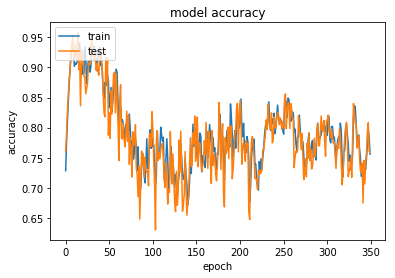

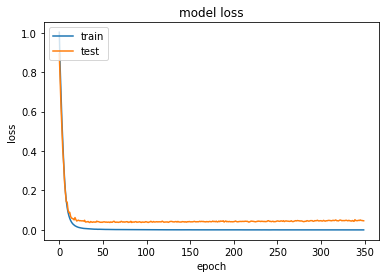

In [17]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
#for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
 #   input_seq = encoder_input_data[seq_index: seq_index + 1]
 #   decoded_sentence = decode_sequence(input_seq)
  #  print('-')
   # print('Input sentence:', input_texts[seq_index])
   # print('Decoded sentence:', decoded_sentence)
    
# Vectorize the data.
test_input_texts = []
test_target_texts = []
test_input_characters = set()
test_target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    test_lines = f.read().split('\n')
for line in test_lines[10005: 11005]:
    test_input_text, test_target_text = line.split(' ')
    # We use space(' ') as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    test_target_text = ' ' + test_target_text + '\n'
    test_input_texts.append(test_input_text)
    test_target_texts.append(test_target_text)
    for char in test_input_text:
        if char not in test_input_characters:
            test_input_characters.add(char)
    for char in test_target_text:
        if char not in test_target_characters:
            test_target_characters.add(char)

test_input_characters = sorted(list(test_input_characters))
test_target_characters = sorted(list(test_target_characters))
test_num_encoder_tokens = len(test_input_characters)
test_num_decoder_tokens = len(test_target_characters)
test_max_encoder_seq_length = max([len(txt) for txt in test_input_texts])
test_max_decoder_seq_length = max([len(txt) for txt in test_target_texts])

print('Number of samples:', len(test_input_texts))
print('Number of unique input tokens:', test_num_encoder_tokens)
print('Number of unique output tokens:', test_num_decoder_tokens)
print('Max sequence length for inputs:', test_max_encoder_seq_length)
print('Max sequence length for outputs:', test_max_decoder_seq_length)

test_input_token_index = dict(
    [(char, i) for i, char in enumerate(test_input_characters)])
test_target_token_index = dict(
    [(char, i) for i, char in enumerate(test_target_characters)])

test_encoder_input_data = np.zeros(
    (len(test_input_texts), test_max_encoder_seq_length, test_num_encoder_tokens),
    dtype='float32')
test_decoder_input_data = np.zeros(
    (len(test_input_texts), test_max_decoder_seq_length, test_num_decoder_tokens),
    dtype='float32')
test_decoder_target_data = np.zeros(
    (len(test_input_texts), test_max_decoder_seq_length, test_num_decoder_tokens),
    dtype='float32')

for i, (test_input_text, test_target_text) in enumerate(zip(test_input_texts, test_target_texts)):
    for t, char in enumerate(test_input_text):
        test_encoder_input_data[i, t, test_input_token_index[char]] = 1.
    for t, char in enumerate(test_target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        test_decoder_input_data[i, t, test_target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            test_decoder_target_data[i, t - 1, test_target_token_index[char]] = 1.

for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    test_input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    print(test_input_seq)
    test_decoded_sentence = decode_sequence(test_input_seq)
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('Decoded sentence:', test_decoded_sentence)

Number of samples: 1000
Number of unique input tokens: 56
Number of unique output tokens: 58
Max sequence length for inputs: 22
Max sequence length for outputs: 22
[[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

ValueError: Error when checking : expected input_1 to have shape (None, 66) but got array with shape (22, 56)

In [16]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models

# Define an input sequence and process it.
test_encoder_inputs = Input(shape=(None, test_num_encoder_tokens))
test_encoder = LSTM(latent_dim, return_state=True)
test_encoder_outputs, test_state_h, test_state_c = test_encoder(test_encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
test_encoder_states = [test_state_h, test_state_c]

test_encoder_model = Model(test_encoder_inputs, test_encoder_states)

test_decoder_inputs = Input(shape=(None, test_num_decoder_tokens))
test_decoder_state_input_h = Input(shape=(latent_dim,))
test_decoder_state_input_c = Input(shape=(latent_dim,))
test_decoder_states_inputs = [test_decoder_state_input_h, test_decoder_state_input_c]
test_decoder_outputs, test_state_h, test_state_c = decoder_lstm(
    test_decoder_inputs, initial_state=test_decoder_states_inputs)
test_decoder_states = [test_state_h, test_state_c]
test_decoder_outputs = decoder_dense(test_decoder_outputs)
test_decoder_model = Model(
    [test_decoder_inputs] + test_decoder_states_inputs,
    [test_decoder_outputs] + test_decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
test_reverse_input_char_index = dict(
    (i, char) for char, i in test_input_token_index.items())
test_reverse_target_char_index = dict(
    (i, char) for char, i in test_target_token_index.items())
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    print("before")
    test_states_value = test_encoder_model.predict(input_seq)
    print("after")
    
    # Generate empty target sequence of length 1.
    test_target_seq = np.zeros((1, 1, test_num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    test_target_seq[0, 0, test_target_token_index[' ']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    test_decoded_sentence = ''
    while not stop_condition:
        test_output_tokens, h, c = test_decoder_model.predict(
            [test_target_seq] + test_states_value)

        # Sample a token
        test_sampled_token_index = np.argmax(test_output_tokens[0, -1, :])
        test_sampled_char = test_reverse_target_char_index[test_sampled_token_index]
        test_decoded_sentence += test_sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (test_sampled_char == '\n' or
           len(test_decoded_sentence) > test_max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        test_target_seq = np.zeros((1, 1, test_num_decoder_tokens))
        test_target_seq[0, 0, test_sampled_token_index] = 1.

        # Update states
        test_states_value = [h, c]

    return test_decoded_sentence

    
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    test_input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    print(test_input_seq)
    test_decoded_sentence = decode_sequence(test_input_seq)
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('Decoded sentence:', test_decoded_sentence)    

ValueError: Layer lstm_2 expects 11 inputs, but it received 3 input tensors. Input received: [<tf.Tensor 'input_24:0' shape=(?, ?, 58) dtype=float32>, <tf.Tensor 'input_25:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'input_26:0' shape=(?, 256) dtype=float32>]